In [1]:
%matplotlib inline

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sqlite
import sys
import random
import matplotlib.patches as mpatches
#import ptitprince as pt

In [2]:
basedir = '/scratch/ias41'
project_dir = '/scratch/ias41/ae_code/psm_effect_inds'
mapped_compounds_db = '/scratch/ias41/ae_code/compound_mapping/results/201903_mapped_compounds_calculon.db'
correlations = '/scratch/ias41/ae_code/psm_aeolus/data/correlations_limited_random_controls.db'
indications_file = basedir + '/ae_code/indications/results/molregno2meddra_inds_via_hlt.pkl'
all_indications_meddra_hier_file = basedir + '/ae_code/indications/data/meddra_terms_indications_hierarchy_output_22_1.xlsx'
all_aes_meddra_hier_file=basedir + '/ae_code/indications/data/all_aeolus_aes_hierarchy_output_22_1.xlsx'

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
# Construct aeolus2molregno dir

# Open sqlite database with aeolus to molregno mappings
conn = sqlite.connect(mapped_compounds_db)
cur = conn.cursor()

# Find aeolus to molregno mappings 
parent_query = """
select distinct aeolus_concept, mapped_parent_molregno
from compound_structures
where mapped_parent_molregno is not null
"""
parent_aeolus_ids = [i for i in cur.execute(parent_query).fetchall()]

conn.close()

# Set up dictionaries
aeolus2molregno = dict()
molregno2aeolus = dict()

# aeolus2molregno should be one molregno per aeolus only
for item in parent_aeolus_ids:
    aeolus2molregno[item[0]] = item[1]
    
# sometimes there are molregnos that are mapped to multiple aeolus_concepts
# Create a set of aeolus_ids per molregno
for item in parent_aeolus_ids:
    try: 
        molregno2aeolus[item[1]].add(item[0])
    except KeyError:
        molregno2aeolus[item[1]] = {item[0]}

### Find indications

In [5]:
with open(indications_file, 'rb') as f:
    indications = pickle.load(f)

# remove where no indications
to_remove = [key for key, value in indications.items() if len(value) < 1]
for key in to_remove:
    del(indications[key])

### Open AE data for PSM and No PSM

In [6]:
all_ae_info_PSM_file = basedir + '/ae_code/faers_aes/results/all_ae_info_PSM_all_random_controls.txt'
all_ae_info_no_PSM_file = basedir + '/ae_code/faers_aes/results/all_ae_info_no_PSM_all_random_controls.txt'

psm_aes_initial = pd.read_csv(all_ae_info_PSM_file, sep='\t')
no_psm_aes_initial = pd.read_csv(all_ae_info_no_PSM_file, sep='\t')

In [7]:
# Number of compounds overlapping between psm_aes and indications
overlapping_molregnos = indications.keys() & set(psm_aes_initial['molregno'].drop_duplicates())
len(overlapping_molregnos), len(psm_aes_initial['molregno'].drop_duplicates()), len(no_psm_aes_initial['molregno'].drop_duplicates())

(1171, 1388, 1322)

In [8]:
# Restrict to compounds overlapping with indications

psm_aes = psm_aes_initial.loc[psm_aes_initial['molregno'].isin(overlapping_molregnos)]
no_psm_aes = no_psm_aes_initial.loc[no_psm_aes_initial['molregno'].isin(overlapping_molregnos)]

def is_indication(row):
    if row['adverse event'].upper() in indications[row['molregno']]:
        return 1
    else:
        return 0
    
psm_aes['indication'] = psm_aes.apply(is_indication, axis=1)
no_psm_aes['indication'] = no_psm_aes.apply(is_indication, axis=1)

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### Merge AE data with indications

In [9]:
# Merge where both have PSM and No PSM info, regardless of indications
merged_df_overlap = psm_aes.merge(no_psm_aes, on=['molregno','adverse event'], suffixes=['_psm', '_no_psm'])

In [10]:
merged_df_overlap.head()

,concept id_psm,adverse event,number of exposed affected_psm,total exposed_psm,number of non-exposed affected_psm,total non-exposed_psm,unique non-exposed_psm,fraction of exposed affected_psm,fraction of non-exposed affected_psm,PRR_psm,chi-squared statistic_psm,chi-squared p-value_psm,comment_psm,corrected p-value_psm,aeolus_id_psm,molregno,indication_psm,concept id_no_psm,number of exposed affected_no_psm,total exposed_no_psm,number of non-exposed affected_no_psm,total non-exposed_no_psm,unique non-exposed_no_psm,fraction of exposed affected_no_psm,fraction of non-exposed affected_no_psm,PRR_no_psm,chi-squared statistic_no_psm,chi-squared p-value_no_psm,comment_no_psm,corrected p-value_no_psm,aeolus_id_no_psm,indication_no_psm
0,36516848,MUSCLE SPASMS,13,1121,36,11210,4988,0.011597,0.003211,3.611111,16.05,6.175833e-05,NaN,5.221386e-04,700253,2166,0,36516848,13,1161,49453,4909224,4909224,0.011197,0.010073,1.111556,0.06,8.131017e-01,NaN,9.183266e-01,700253,0
1,36718526,CONVULSION,47,1121,169,11210,4988,0.041927,0.015076,2.781065,41.15,1.412140e-10,NaN,3.283226e-09,700253,2166,0,36718526,52,1161,57793,4909224,4909224,0.044789,0.011772,3.804598,105.87,7.862153e-25,NaN,6.861515e-24,700253,0
2,36311983,HEART RATE INCREASED,29,1121,121,11210,4988,0.025870,0.010794,2.396694,18.04,2.162030e-05,NaN,2.234097e-04,700253,2166,0,36311983,30,1161,29824,4909224,4909224,0.025840,0.006075,4.253398,71.80,2.380124e-17,NaN,1.757630e-16,700253,0
3,36211195,DRUG EXPOSURE DURING PREGNANCY,61,1121,256,11210,4988,0.054416,0.022837,2.382812,39.32,3.590134e-10,NaN,7.419609e-09,700253,2166,0,36211195,63,1161,33999,4909224,4909224,0.054264,0.006926,7.835289,370.75,1.286580e-82,NaN,3.087792e-81,700253,0
4,37320158,ERYTHEMA,29,1121,125,11210,4988,0.025870,0.011151,2.320000,16.73,4.312678e-05,NaN,4.010791e-04,700253,2166,0,37320158,30,1161,45717,4909224,4909224,0.025840,0.009312,2.774752,32.58,1.141104e-08,NaN,6.085887e-08,700253,0


In [11]:
# Then define merged with indications
merged_df_ind_overlap = psm_aes.loc[psm_aes['indication']==1].merge(no_psm_aes.loc[no_psm_aes['indication']==1], on=['molregno','adverse event'], suffixes=['_psm', '_no_psm'])

In [12]:
# Then define merged with non-indications
merged_df_no_ind_overlap = psm_aes.loc[psm_aes['indication']==0].merge(no_psm_aes.loc[no_psm_aes['indication']==0], on=['molregno','adverse event'], suffixes=['_psm', '_no_psm'])

In [13]:
# Define concatenated dataframe with indications
psm_aes['PSM'] = 'PSM'
no_psm_aes['PSM'] = 'No PSM'
concat_df = pd.concat([psm_aes, no_psm_aes])
concat_df_inds = concat_df.loc[concat_df['indication']==1]
concat_df_no_inds = concat_df.loc[concat_df['indication']==0]

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
concat_df.head()

,concept id,adverse event,number of exposed affected,total exposed,number of non-exposed affected,total non-exposed,unique non-exposed,fraction of exposed affected,fraction of non-exposed affected,PRR,chi-squared statistic,chi-squared p-value,comment,corrected p-value,aeolus_id,molregno,indication,PSM
0,36211188,THERAPEUTIC AGENT TOXICITY,27,1121,29,11210,4988,0.024086,0.002587,9.310345,99.49,1.973580e-23,NaN,1.835429e-21,700253,2166,0,PSM
1,36818729,PREMATURE BABY,34,1121,40,11210,4988,0.030330,0.003568,8.500000,117.91,1.813784e-27,NaN,3.373638e-25,700253,2166,0,PSM
2,36718119,ENCEPHALOPATHY,29,1121,39,11210,4988,0.025870,0.003479,7.435897,89.12,3.707871e-21,NaN,2.298880e-19,700253,2166,0,PSM
3,36211197,MATERNAL DRUGS AFFECTING FOETUS,22,1121,30,11210,4988,0.019625,0.002676,7.333333,65.74,5.147074e-16,NaN,2.393390e-14,700253,2166,0,PSM
4,36718298,APHASIA,19,1121,27,11210,4988,0.016949,0.002409,7.037037,54.13,1.877924e-13,NaN,5.821565e-12,700253,2166,0,PSM


### PRR distributions for PSM and No PSM

In [15]:
len(concat_df['molregno'].drop_duplicates())

1171

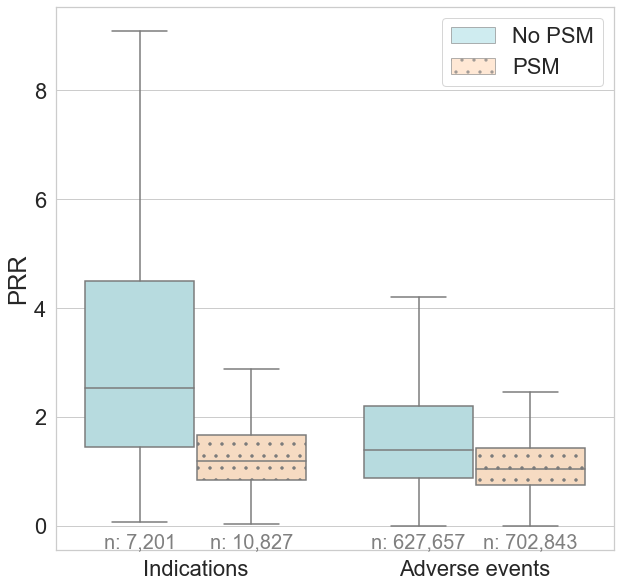

In [19]:
medians = concat_df.groupby(['indication','PSM'])['PRR'].median()
nobs =  concat_df.groupby(['indication','PSM']).apply(lambda x: 'n: {:,}'.format(len(x)))

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

ax = sns.boxplot(x="indication", y="PRR", hue="PSM",data=concat_df, palette=['Powderblue', 'peachpuff'], showfliers=False, orient='v', hue_order=['No PSM', 'PSM'], order=[1,0])

hatches = {'even': "."}
for num, patch in enumerate(ax.artists):
    if (num % 2) == 0:
        patch.set_hatch('')
    else:
        patch.set_hatch(hatches['even'])


circ1 = mpatches.Patch( facecolor='peachpuff',alpha=0.6,hatch='.',label='PSM', edgecolor='grey')
circ2= mpatches.Patch( facecolor='Powderblue',alpha=0.6,hatch='',label='No PSM', edgecolor='grey')

ax.legend(handles = [circ2,circ1])
 
        
for tick, label in enumerate(ax.get_xticklabels()):
    ax_sex = label.get_text()

    for j, ax_smoker in enumerate(ax.get_legend_handles_labels()[1]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[int(ax_sex), ax_smoker]
        num = nobs[int(ax_sex), ax_smoker]

        ax.text(tick + x_offset, -0.4, num, # med_val + 0.1
                horizontalalignment='center', size='small', color='grey')


ax.set_xticklabels(['Indications', 'Adverse events'])
ax.set(xlabel='')
#ax.legend().set_title('')
plt.savefig(project_dir + '/figures/PRR_byInd_psm_vs_no_psm.png', bbox_inches='tight')

### Change in PRR

In [20]:
# Difference per specific adverse event 
observe_diffs = merged_df_overlap.copy()
observe_diffs['PRR after - PRR before'] =  observe_diffs['PRR_psm'] - observe_diffs['PRR_no_psm']

In [21]:
len(observe_diffs.loc[observe_diffs['indication_psm']==1,:])

7109

In [22]:
len(observe_diffs['molregno'].drop_duplicates())

1119

In [23]:
observe_diffs.head()

,concept id_psm,adverse event,number of exposed affected_psm,total exposed_psm,number of non-exposed affected_psm,total non-exposed_psm,unique non-exposed_psm,fraction of exposed affected_psm,fraction of non-exposed affected_psm,PRR_psm,chi-squared statistic_psm,chi-squared p-value_psm,comment_psm,corrected p-value_psm,aeolus_id_psm,molregno,indication_psm,concept id_no_psm,number of exposed affected_no_psm,total exposed_no_psm,number of non-exposed affected_no_psm,total non-exposed_no_psm,unique non-exposed_no_psm,fraction of exposed affected_no_psm,fraction of non-exposed affected_no_psm,PRR_no_psm,chi-squared statistic_no_psm,chi-squared p-value_no_psm,comment_no_psm,corrected p-value_no_psm,aeolus_id_no_psm,indication_no_psm,PRR after - PRR before
0,36516848,MUSCLE SPASMS,13,1121,36,11210,4988,0.011597,0.003211,3.611111,16.05,6.175833e-05,NaN,5.221386e-04,700253,2166,0,36516848,13,1161,49453,4909224,4909224,0.011197,0.010073,1.111556,0.06,8.131017e-01,NaN,9.183266e-01,700253,0,2.499555
1,36718526,CONVULSION,47,1121,169,11210,4988,0.041927,0.015076,2.781065,41.15,1.412140e-10,NaN,3.283226e-09,700253,2166,0,36718526,52,1161,57793,4909224,4909224,0.044789,0.011772,3.804598,105.87,7.862153e-25,NaN,6.861515e-24,700253,0,-1.023533
2,36311983,HEART RATE INCREASED,29,1121,121,11210,4988,0.025870,0.010794,2.396694,18.04,2.162030e-05,NaN,2.234097e-04,700253,2166,0,36311983,30,1161,29824,4909224,4909224,0.025840,0.006075,4.253398,71.80,2.380124e-17,NaN,1.757630e-16,700253,0,-1.856703
3,36211195,DRUG EXPOSURE DURING PREGNANCY,61,1121,256,11210,4988,0.054416,0.022837,2.382812,39.32,3.590134e-10,NaN,7.419609e-09,700253,2166,0,36211195,63,1161,33999,4909224,4909224,0.054264,0.006926,7.835289,370.75,1.286580e-82,NaN,3.087792e-81,700253,0,-5.452477
4,37320158,ERYTHEMA,29,1121,125,11210,4988,0.025870,0.011151,2.320000,16.73,4.312678e-05,NaN,4.010791e-04,700253,2166,0,37320158,30,1161,45717,4909224,4909224,0.025840,0.009312,2.774752,32.58,1.141104e-08,NaN,6.085887e-08,700253,0,-0.454752


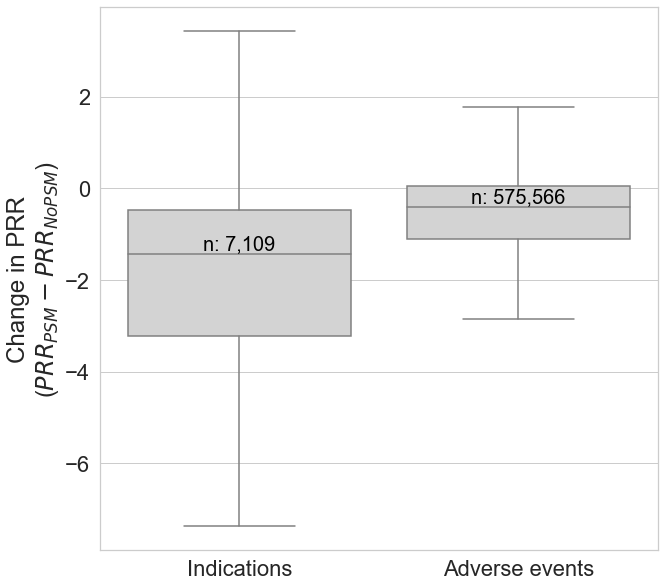

In [25]:
medians = observe_diffs.groupby(['indication_psm'])['PRR after - PRR before'].median()
nobs =  observe_diffs.groupby(['indication_psm']).apply(lambda x: 'n: {:,}'.format(len(x)))

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

ax = sns.boxplot(y='PRR after - PRR before', x='indication_psm', data=observe_diffs, orient='v', showfliers=False, color='lightgrey', order=[1,0])


for tick, label in enumerate(ax.get_xticklabels()):
    ax_sex = label.get_text()
    num = nobs[int(ax_sex)]
    med_val= medians[int(ax_sex)]

    ax.text(tick , med_val + 0.1, num,
                horizontalalignment='center', size='small', color='black')

ax.set_xticklabels(['Indications', 'Adverse events'])

ax.set(xlabel='', ylabel='Change in PRR\n($PRR_{PSM} - PRR_{NoPSM}$)')

plt.savefig(project_dir + '/figures/Change_PRR_byInd_psm_vs_no_psm.png', bbox_inches='tight')

### Correlate PSM effect with sample size

In [26]:
# Difference per specific adverse event 
observe_diffs = merged_df_ind_overlap.copy()
observe_diffs['PRR after - PRR before'] =  observe_diffs['PRR_psm'] - observe_diffs['PRR_no_psm']
observe_diffs['PRR after - PRR before'].describe()

count    7109.000000
mean       -3.951752
std        23.592268
min     -1496.538010
25%        -3.225510
50%        -1.434316
75%        -0.471406
max        25.531167
Name: PRR after - PRR before, dtype: float64

In [27]:
observe_diffs.columns

Index(['concept id_psm', 'adverse event', 'number of exposed affected_psm',
       'total exposed_psm', 'number of non-exposed affected_psm',
       'total non-exposed_psm', 'unique non-exposed_psm',
       'fraction of exposed affected_psm',
       'fraction of non-exposed affected_psm', 'PRR_psm',
       'chi-squared statistic_psm', 'chi-squared p-value_psm', 'comment_psm',
       'corrected p-value_psm', 'aeolus_id_psm', 'molregno', 'indication_psm',
       'concept id_no_psm', 'number of exposed affected_no_psm',
       'total exposed_no_psm', 'number of non-exposed affected_no_psm',
       'total non-exposed_no_psm', 'unique non-exposed_no_psm',
       'fraction of exposed affected_no_psm',
       'fraction of non-exposed affected_no_psm', 'PRR_no_psm',
       'chi-squared statistic_no_psm', 'chi-squared p-value_no_psm',
       'comment_no_psm', 'corrected p-value_no_psm', 'aeolus_id_no_psm',
       'indication_no_psm', 'PRR after - PRR before'],
      dtype='object')

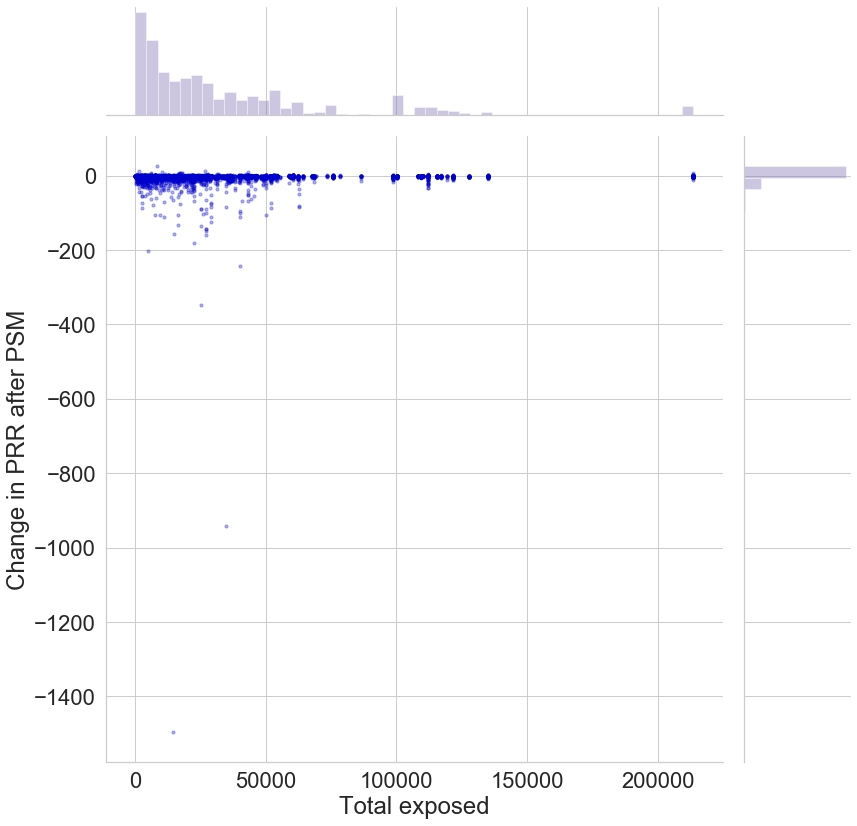

In [28]:
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(25,25)})
sns.set_style('whitegrid')

g = sns.jointplot(x="total exposed_psm", y="PRR after - PRR before", data=observe_diffs, color="m", height=12) # ylim=(-2200,400)
g.plot_joint(plt.scatter, c="MediumBlue", s=10, linewidth=1, alpha=0.3)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Total exposed", "Change in PRR after PSM")
plt.savefig(project_dir + '/figures/SampleSize_change_scatter.png', bbox_inches='tight')

In [29]:
observe_sample_size = observe_diffs.copy()
observe_sample_size['amplification'] = 1 - (observe_sample_size['unique non-exposed_psm'] / observe_sample_size['total non-exposed_psm'])

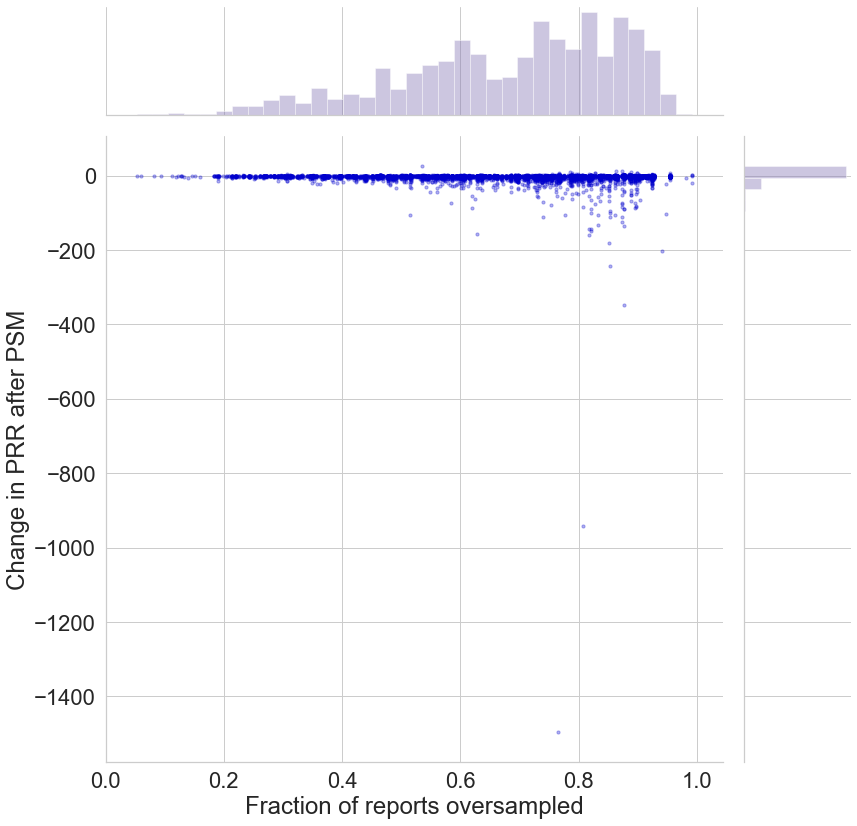

In [30]:
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(25,25)})
sns.set_style('whitegrid')

g = sns.jointplot(x="amplification", y="PRR after - PRR before", data=observe_sample_size, color="m", height=12) # ylim=(-2200,400)
g.plot_joint(plt.scatter, c="MediumBlue", s=10, linewidth=1, alpha=0.3)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Fraction of reports oversampled", "Change in PRR after PSM")
plt.savefig(project_dir + '/figures/Amplification_change_scatter.png', bbox_inches='tight')

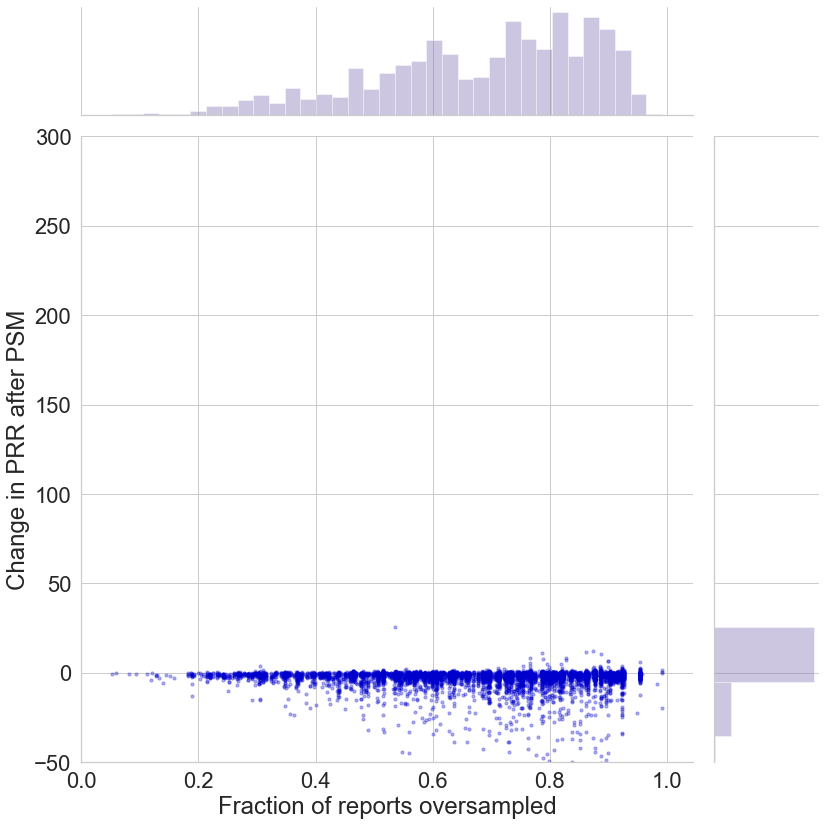

In [31]:
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(25,25)})
sns.set_style('whitegrid')

g = sns.jointplot(x="amplification", y="PRR after - PRR before", data=observe_sample_size, color="m", height=12, ylim=(-50,300)) # ylim=(-2200,400)
g.plot_joint(plt.scatter, c="MediumBlue", s=10, linewidth=1, alpha=0.3)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Fraction of reports oversampled", "Change in PRR after PSM")
#plt.savefig(project_dir + '/figures/Amplification_change_scatter_zoom.png', bbox_inches='tight')

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Difference in PRR for indications (low amplification)\n($PRR_{PSM} - PRR_{NoPSM}$)')]

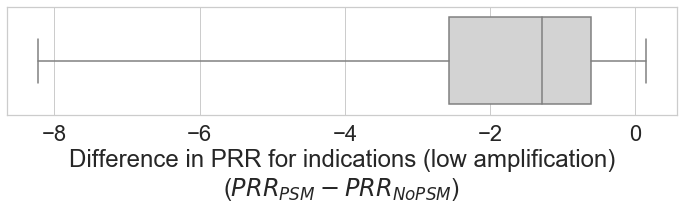

In [32]:
sns.set(rc={'figure.figsize':(12,2)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

ax = sns.boxplot(observe_sample_size.loc[observe_sample_size['amplification']<0.5,:]['PRR after - PRR before'], color='lightgrey', orient='h', showfliers=False, whis=[5,95])
#ax.set_xlim(-25,25)
#ax.text(1.05,0.45, f'n = {len(observe_diffs)}\ndrug-indication pairs', transform=ax.transAxes, size=15)
ax.set(ylabel='', xlabel='Difference in PRR for indications (low amplification)\n($PRR_{PSM} - PRR_{NoPSM}$)')
#plt.savefig(project_dir + '/figures/Amplification_change_boxplot.png', bbox_inches='tight')

In [33]:
len(observe_sample_size), len(observe_sample_size['molregno'].drop_duplicates()), len(observe_sample_size['adverse event'].drop_duplicates())

(7109, 704, 1312)

In [34]:
observe_sample_size_low_ampl = observe_sample_size.loc[observe_sample_size['amplification']<0.5,:]
len(observe_sample_size_low_ampl), len(observe_sample_size_low_ampl['molregno'].drop_duplicates()), len(observe_sample_size_low_ampl['adverse event'].drop_duplicates())

(1153, 270, 312)

### Reduction of PRR by SOC of indication/AE

In [35]:
# Open hierarchy analysis file
# Open file with HLTs for all AE meddra terms
meddra_hlgt = pd.read_excel(all_aes_meddra_hier_file,skiprows=4)
meddra_hlgt.columns = ['Row ID', 'Term', 'Code', 'Level', 'PT', 'PT Code', 'HLT', 'HLT Code',
       'HLGT', 'HLGT Code', 'SOC', 'SOC Code', 'Primary SOC']
meddra_hlgt['Term'] = [i.upper() for i in meddra_hlgt['Term']]
meddra_hlgt['PT'] = [i.upper() for i in meddra_hlgt['PT']]

In [36]:
meddra_hlgt_inds = pd.read_excel(all_indications_meddra_hier_file,skiprows=4)
meddra_hlgt_inds.columns = ['Row ID', 'Term', 'Code', 'Level', 'PT', 'PT Code', 'HLT', 'HLT Code',
       'HLGT', 'HLGT Code', 'SOC', 'SOC Code', 'Primary SOC']
meddra_hlgt_inds['Term'] = [i.upper() for i in meddra_hlgt_inds['Term']]

In [37]:
# Make term to SOC dict

term2soc= dict()
    
for row in meddra_hlgt.loc[meddra_hlgt['Primary SOC']=='Y',['Term','SOC']].iterrows():
    term = row[1]['Term']
    soc = row[1]['SOC']
    term2soc[term] = soc
    
for row in meddra_hlgt_inds.loc[meddra_hlgt_inds['Primary SOC']=='Y',['Term','SOC']].iterrows():
    term = row[1]['Term']
    soc = row[1]['SOC']
    term2soc[term] = soc

In [38]:
observe_diffs.head()

,concept id_psm,adverse event,number of exposed affected_psm,total exposed_psm,number of non-exposed affected_psm,total non-exposed_psm,unique non-exposed_psm,fraction of exposed affected_psm,fraction of non-exposed affected_psm,PRR_psm,chi-squared statistic_psm,chi-squared p-value_psm,comment_psm,corrected p-value_psm,aeolus_id_psm,molregno,indication_psm,concept id_no_psm,number of exposed affected_no_psm,total exposed_no_psm,number of non-exposed affected_no_psm,total non-exposed_no_psm,unique non-exposed_no_psm,fraction of exposed affected_no_psm,fraction of non-exposed affected_no_psm,PRR_no_psm,chi-squared statistic_no_psm,chi-squared p-value_no_psm,comment_no_psm,corrected p-value_no_psm,aeolus_id_no_psm,indication_no_psm,PRR after - PRR before
0,36718157,DEMENTIA ALZHEIMER'S TYPE,204,9178,865,91780,17263,0.022227,0.009425,2.358382,129.31,5.789289e-30,NaN,1.182462e-27,701322,52523,1,36718157,209,10130,2534,4900255,4900255,0.020632,0.000517,39.897796,7290.08,0.000000,NaN,0.000000,701322,1,-37.539415
1,35205185,CHEST PAIN,6,388,48,3880,2239,0.015464,0.012371,1.250000,0.08,7.783254e-01,NaN,9.112103e-01,702774,147981,1,35205185,6,431,68207,4909954,4909954,0.013921,0.013892,1.002126,0.04,0.841054,NaN,0.962299,702774,1,0.247874
2,35809243,PAIN,7,388,105,3880,2239,0.018041,0.027062,0.666667,0.80,3.717074e-01,NaN,6.372127e-01,702774,147981,1,35809243,9,431,143798,4909954,4909954,0.020882,0.029287,0.713000,0.80,0.372365,NaN,0.651638,702774,1,-0.046334
3,36718132,HEADACHE,27,1783,601,17830,10125,0.015143,0.033707,0.449251,17.43,2.982201e-05,NaN,2.553510e-04,702865,99389,1,36718132,30,1874,160377,4908511,4908511,0.016009,0.032673,0.489959,15.94,0.000065,NaN,0.000236,702865,1,-0.040707
4,36919158,SCHIZOPHRENIA,248,12578,1477,125780,42899,0.019717,0.011743,1.679079,58.41,2.128331e-14,NaN,2.078253e-13,703244,468656,1,36919158,249,12792,2367,4897593,4897593,0.019465,0.000483,40.275907,8598.12,0.000000,NaN,0.000000,703244,1,-38.596828


In [39]:
observe_diffs['indication_psm'].drop_duplicates()

0    1
Name: indication_psm, dtype: int64

In [40]:
observe_socs = observe_diffs.copy()
observe_socs['SOC'] = observe_socs['adverse event'].apply(lambda x: term2soc[x])

In [41]:
observe_socs.loc[observe_socs['SOC']=='Product issues']

,concept id_psm,adverse event,number of exposed affected_psm,total exposed_psm,number of non-exposed affected_psm,total non-exposed_psm,unique non-exposed_psm,fraction of exposed affected_psm,fraction of non-exposed affected_psm,PRR_psm,chi-squared statistic_psm,chi-squared p-value_psm,comment_psm,corrected p-value_psm,aeolus_id_psm,molregno,indication_psm,concept id_no_psm,number of exposed affected_no_psm,total exposed_no_psm,number of non-exposed affected_no_psm,total non-exposed_no_psm,unique non-exposed_no_psm,fraction of exposed affected_no_psm,fraction of non-exposed affected_no_psm,PRR_no_psm,chi-squared statistic_no_psm,chi-squared p-value_no_psm,comment_no_psm,corrected p-value_no_psm,aeolus_id_no_psm,indication_no_psm,PRR after - PRR before,SOC
3181,36211603,THROMBOSIS IN DEVICE,103,75852,711,758520,92782,0.001358,0.000937,1.448664,12.09,0.000508,NaN,0.002207,1310149,394165,1,36211603,132,98238,1885,4812147,4812147,0.001344,0.000392,3.430220,210.17,1.259790e-47,NaN,1.280461e-46,1310149,1,-1.981556,Product issues
6788,36211603,THROMBOSIS IN DEVICE,47,20054,607,200540,63104,0.002344,0.003027,0.774300,2.65,0.103424,NaN,0.268009,1301025,675454,1,36211603,66,25861,1951,4884524,4884524,0.002552,0.000399,6.389452,285.12,5.765232e-64,NaN,7.990326e-63,1301025,1,-5.615152,Product issues


In [42]:
# Exclude categories with less than 5 samples
soc_total_counts = pd.DataFrame(observe_socs['SOC'].value_counts())
under_6 = [i for i in soc_total_counts.loc[soc_total_counts['SOC']<6].index]

In [43]:
# Exclude SOC 'Product issues' because only 2 datapoints so no point in showing distribution
observe_socs_min_samples = observe_socs.loc[~observe_socs['SOC'].isin(under_6)]

In [44]:
SOC_order = list(pd.DataFrame(observe_socs_min_samples.groupby('SOC')['PRR after - PRR before'].median()).sort_values(by='PRR after - PRR before').index)

In [45]:
observe_socs_min_samples['SOC'] = observe_socs_min_samples['SOC'].astype('category')
observe_socs_min_samples['SOC'].cat.set_categories(SOC_order, inplace=True)

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
pd.DataFrame(observe_socs_min_samples.groupby('SOC')['adverse event'].count()).reset_index().sum()

SOC              Neoplasms benign, malignant and unspecified (i...
adverse event                                                 7107
dtype: object

In [47]:
# Number of drugs per SOC
custom_labels = [row[1]['SOC'] + ' (n=' + str(row[1]['adverse event']) + ')' for row in pd.DataFrame(observe_socs_min_samples.groupby('SOC')['adverse event'].count()).reset_index().sort_values(by='SOC').iterrows()]
custom_labels

['Neoplasms benign, malignant and unspecified (incl cysts and polyps) (n=364)',
 'Metabolism and nutrition disorders (n=236)',
 'Cardiac disorders (n=1016)',
 'Endocrine disorders (n=60)',
 'Psychiatric disorders (n=357)',
 'Ear and labyrinth disorders (n=8)',
 'Infections and infestations (n=624)',
 'Respiratory, thoracic and mediastinal disorders (n=426)',
 'Investigations (n=38)',
 'Musculoskeletal and connective tissue disorders (n=412)',
 'Vascular disorders (n=135)',
 'Blood and lymphatic system disorders (n=148)',
 'Renal and urinary disorders (n=280)',
 'Nervous system disorders (n=551)',
 'Gastrointestinal disorders (n=485)',
 'Hepatobiliary disorders (n=43)',
 'Immune system disorders (n=256)',
 'Eye disorders (n=96)',
 'Injury, poisoning and procedural complications (n=385)',
 'Pregnancy, puerperium and perinatal conditions (n=17)',
 'Reproductive system and breast disorders (n=97)',
 'General disorders and administration site conditions (n=724)',
 'Skin and subcutaneous tis

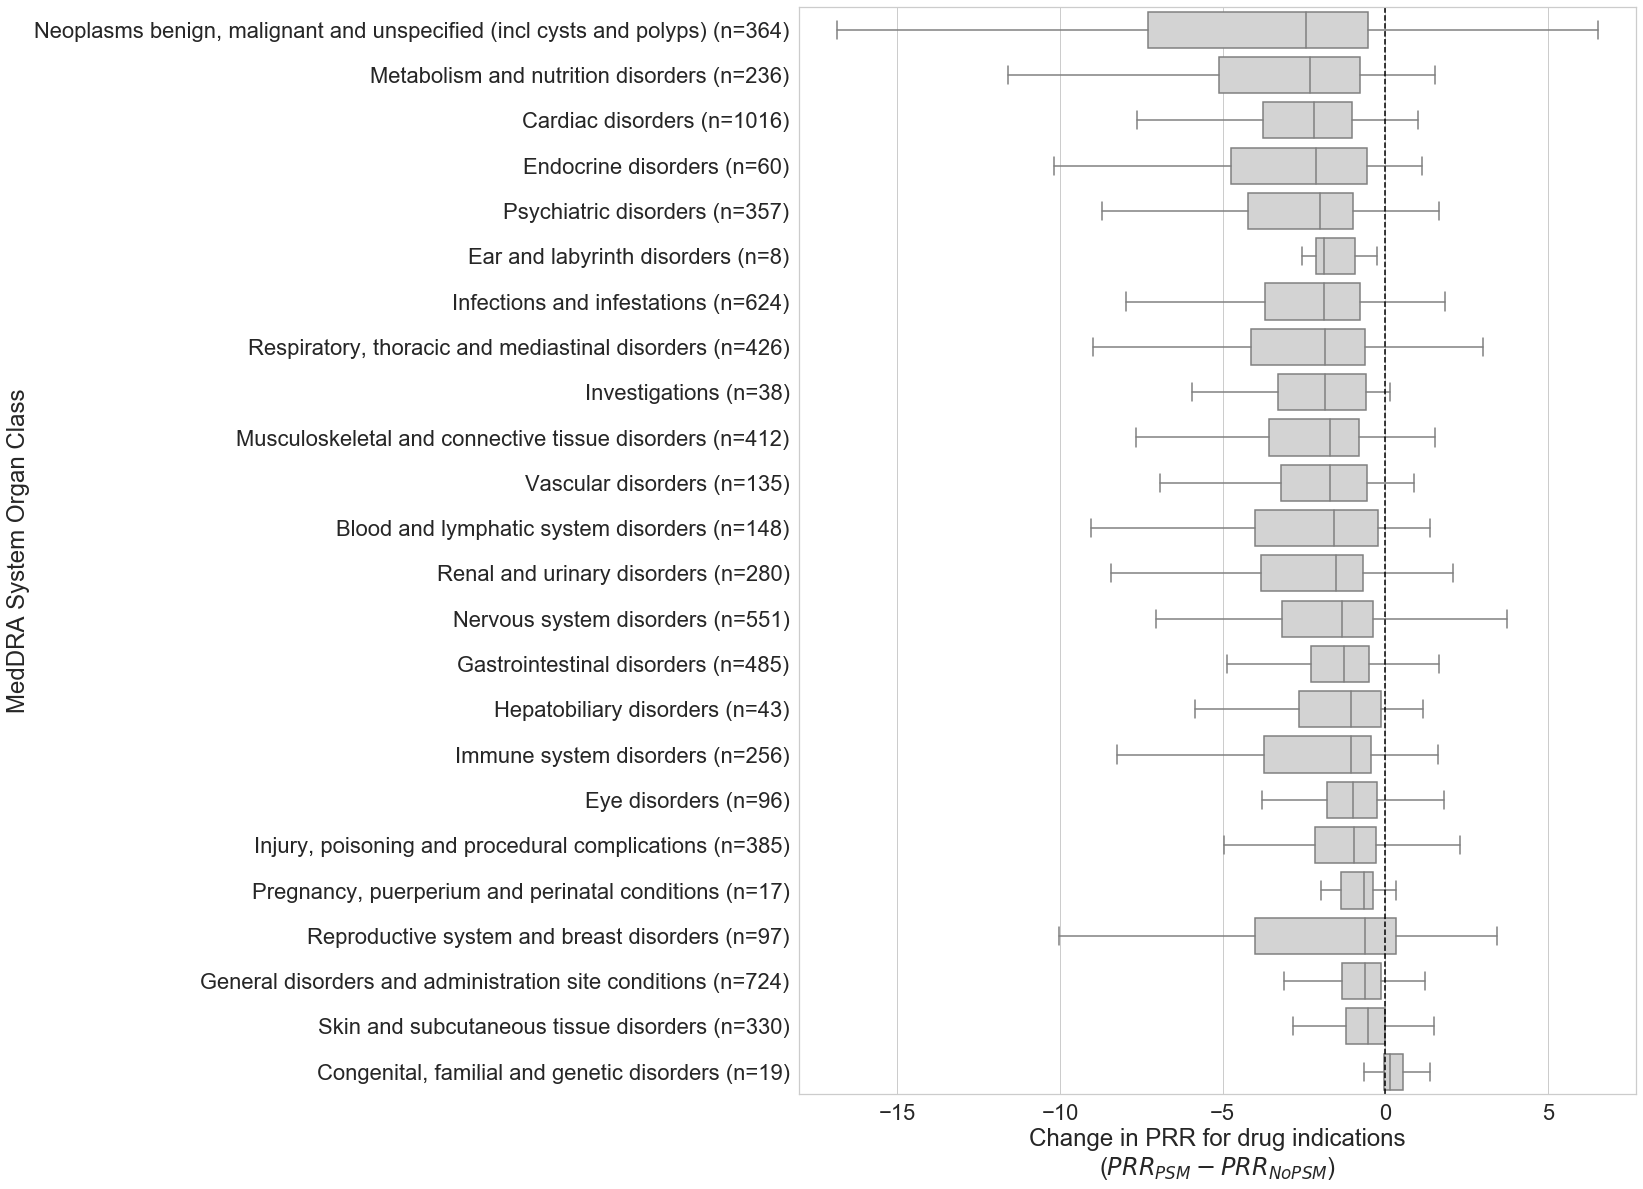

In [48]:
sns.set(rc={'figure.figsize':(15,20)})
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.boxplot(y="SOC", x="PRR after - PRR before",data=observe_socs_min_samples,color='lightgrey', orient='h', order=SOC_order, showfliers=False)
ax.axvline(0, linestyle='--', color='black')
#ax.set_xlim(-40,25)
ax.set_ylabel("MedDRA System Organ Class")
ax.set_xlabel("Change in PRR for drug indications\n($PRR_{PSM} - PRR_{NoPSM}$)")
ax.set_yticklabels(custom_labels)
plt.savefig(project_dir + '/figures/PRR_change_by_SOC.png', bbox_inches='tight')

In [49]:
# Difference per specific adverse event 
observe_diffs_all = merged_df_overlap.copy()
observe_diffs_all['PRR after - PRR before'] =  observe_diffs_all['PRR_psm'] - observe_diffs_all['PRR_no_psm']

In [50]:
observe_diffs_all['indication_psm'].drop_duplicates()

0      0
275    1
Name: indication_psm, dtype: int64

In [51]:
observe_socs = observe_diffs_all.copy()
observe_socs['SOC'] = observe_socs['adverse event'].apply(lambda x: term2soc[x])

In [52]:
# Exclude categories with less than 5 samples
soc_total_counts = pd.DataFrame(observe_socs.groupby('indication_psm')['SOC'].value_counts())
under_6 = [i[1] for i in soc_total_counts.loc[soc_total_counts['SOC']<6].index]

In [53]:
# Exclude SOC 'Product issues' because only 2 datapoints so no point in showing distribution
observe_socs_min_samples = observe_socs.loc[~observe_socs['SOC'].isin(under_6)]

In [54]:
medians = observe_socs_min_samples.groupby(['SOC','indication_psm'])['PRR after - PRR before'].median()
nobs =  observe_socs_min_samples.groupby(['SOC','indication_psm']).apply(lambda x: 'n: {:,}'.format(len(x)))

In [55]:
SOC_order = list(pd.DataFrame(observe_socs_min_samples.loc[observe_socs_min_samples['indication_psm']==1].groupby('SOC')['PRR after - PRR before'].median()).sort_values(by='PRR after - PRR before').index)

In [56]:
observe_socs_min_samples['SOC'] = observe_socs_min_samples['SOC'].astype('category')
observe_socs_min_samples['SOC'].cat.set_categories(SOC_order, inplace=True)

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


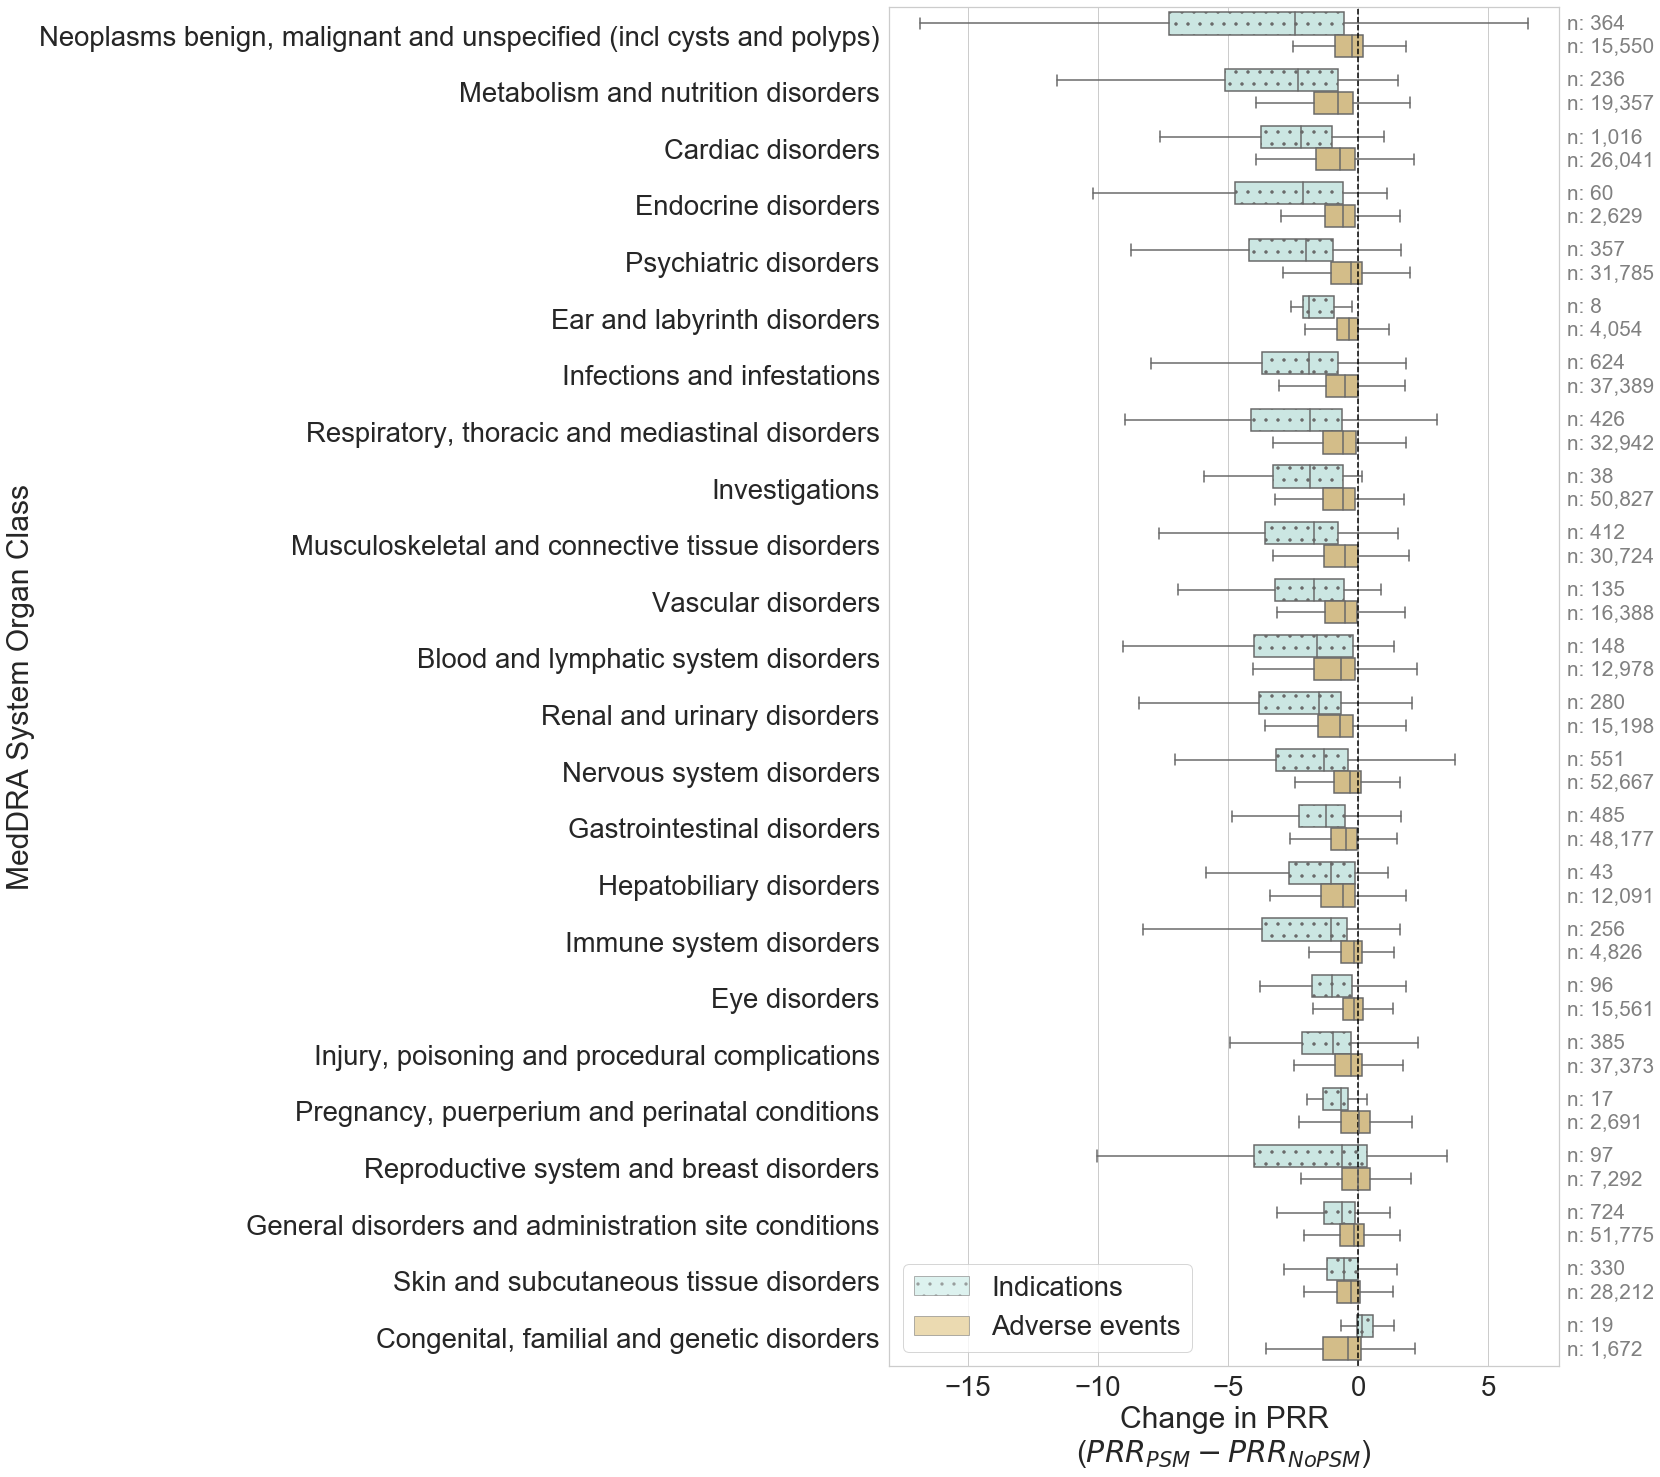

In [61]:
sns.set(rc={'figure.figsize':(12,25)})
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
ax = sns.boxplot(y="SOC", x="PRR after - PRR before",data=observe_socs_min_samples,palette=['#c7eae5','#dfc27d'], orient='h', order=SOC_order,showfliers=False, hue='indication_psm', hue_order=[1,0])

hatches = {'even': ".", 'odd': ''}
for num, patch in enumerate(ax.artists):
    if (num % 2) == 0:
        patch.set_hatch(hatches['even'])
    else:
        patch.set_hatch('')


for tick, label in enumerate(ax.get_yticklabels()):
    ax_sex = label.get_text()

    for j, ax_smoker in enumerate(ax.get_legend_handles_labels()[1]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ax_sex, int(ax_smoker)]
        num = nobs[ax_sex, int(ax_smoker)]

        ax.text(8, tick + x_offset, num,  verticalalignment='center', size='x-small', color='grey')


circ1 = mpatches.Patch( facecolor='#c7eae5',alpha=0.6,hatch='.',label='Indications', edgecolor='grey')
circ2= mpatches.Patch( facecolor='#dfc27d',alpha=0.6,hatch='',label='Adverse events', edgecolor='grey')
ax.legend(handles = [circ1,circ2])
        
ax.axvline(0, linestyle='--', color='black')
#ax.set_xlim(-40,25)
ax.set_ylabel("MedDRA System Organ Class")
ax.set_xlabel("Change in PRR\n($PRR_{PSM} - PRR_{NoPSM}$)")
#ax.legend().set_title('')
#h,l = ax.get_legend_handles_labels()
#ax.legend(handles=h, labels=['Adverse events', 'Indications'])
plt.savefig(project_dir + '/figures/PRR_bySOC_byInd.png', bbox_inches='tight', dpi=100)

### What is most abundant AE=indication SOC or AEs?

In [62]:
AE_counts = pd.DataFrame(observe_socs.loc[observe_socs['indication_psm']==1].groupby('adverse event')['adverse event'].count())
AE_counts.rename(columns={'adverse event': 'adverse event count'}, inplace=True)

In [63]:
AE_selection = list(AE_counts.sort_values(by='adverse event count', ascending=False).index)[:20]
AE_selection

['PAIN',
 'CHEST PAIN',
 'MYOCARDIAL INFARCTION',
 'ANGINA PECTORIS',
 'ACUTE MYOCARDIAL INFARCTION',
 'CORONARY ARTERY DISEASE',
 'CHEST DISCOMFORT',
 'CARDIAC FAILURE CONGESTIVE',
 'URINARY TRACT INFECTION',
 'INTERSTITIAL LUNG DISEASE',
 'CARDIAC FAILURE',
 'MYOCARDIAL ISCHAEMIA',
 'CORONARY ARTERY OCCLUSION',
 'DEPRESSION',
 'PROCEDURAL PAIN',
 'ASTHMA',
 'DISCOMFORT',
 'PSORIASIS',
 'CELLULITIS',
 'HYPERSENSITIVITY']

In [64]:
psm_aes['PSM'] = 'PSM'
no_psm_aes['PSM'] = 'No PSM'
concat_df = pd.concat([psm_aes, no_psm_aes])
concat_df_inds = concat_df.loc[concat_df['indication']==1]
concat_df_no_inds = concat_df.loc[concat_df['indication']==0]


/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
current_df = concat_df_inds.loc[concat_df_inds['adverse event'].isin(AE_selection)]
AE_order = list(pd.DataFrame(current_df.loc[current_df['PSM']=='No PSM',:].groupby('adverse event')['PRR'].quantile(0.75)).sort_values(by='PRR', ascending=False).index)

current_df['adverse event'] = current_df['adverse event'].astype('category')
current_df['adverse event'].cat.set_categories(AE_order, inplace=True)

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [66]:
AE_order

['ASTHMA',
 'CARDIAC FAILURE',
 'CARDIAC FAILURE CONGESTIVE',
 'CORONARY ARTERY OCCLUSION',
 'CORONARY ARTERY DISEASE',
 'INTERSTITIAL LUNG DISEASE',
 'ACUTE MYOCARDIAL INFARCTION',
 'ANGINA PECTORIS',
 'MYOCARDIAL ISCHAEMIA',
 'URINARY TRACT INFECTION',
 'CELLULITIS',
 'DEPRESSION',
 'PAIN',
 'CHEST PAIN',
 'CHEST DISCOMFORT',
 'MYOCARDIAL INFARCTION',
 'HYPERSENSITIVITY',
 'DISCOMFORT',
 'PROCEDURAL PAIN',
 'PSORIASIS']

In [67]:
custom_ae_labels = [row[1]['adverse event'] + ' (n=' + str(row[1]['aeolus_id']) + ' drugs)' for row in pd.DataFrame(current_df.groupby('adverse event')['aeolus_id'].nunique()).reset_index().sort_values(by='adverse event').iterrows()]

In [68]:
hatches = {'even': ".", 'odd': ''}
for num, patch in enumerate(ax.artists):
    if (num % 2) == 0:
        patch.set_hatch(hatches['even'])
    else:
        patch.set_hatch('')

circ1 = mpatches.Patch( facecolor='#c7eae5',alpha=0.6,hatch='.',label='Indications', edgecolor='black')
circ2= mpatches.Patch( facecolor='#dfc27d',alpha=0.6,hatch='',label='Adverse events')
ax.legend(handles = [circ1,circ2])


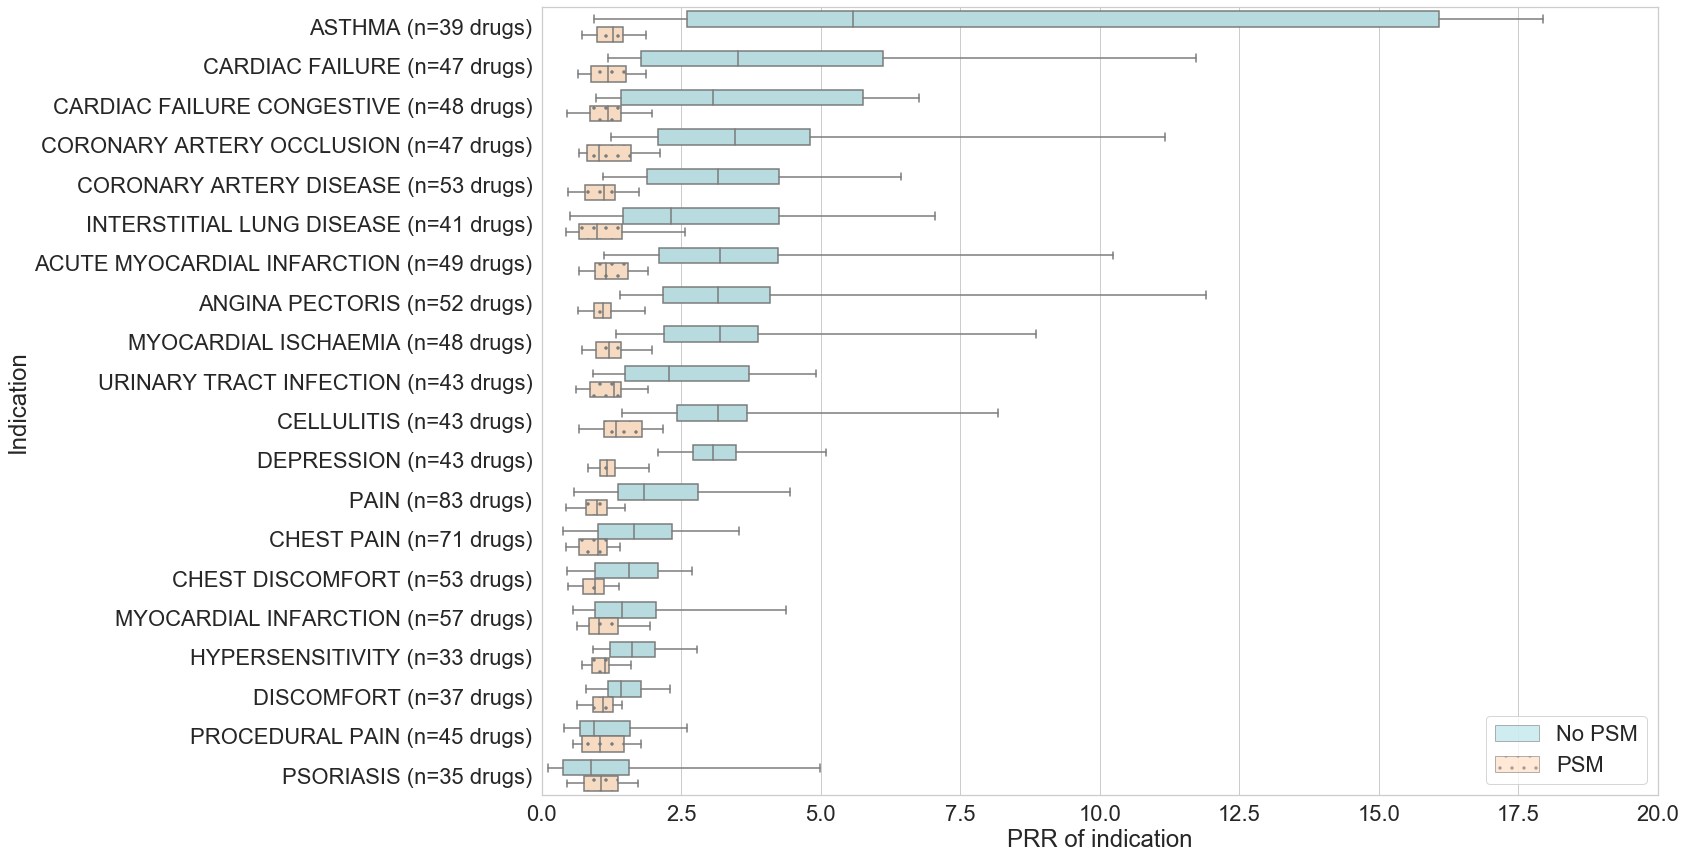

In [69]:
sns.set(rc={'figure.figsize':(20,14.5)})
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.boxplot(y="adverse event", x="PRR", hue="PSM",data=current_df, palette=['Powderblue', 'peachpuff'], whis=[5, 95], showfliers=False, orient='h', hue_order=['No PSM', 'PSM'], order=AE_order)

#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

hatches = {'even': ".", 'odd': ''}
for num, patch in enumerate(ax.artists):
    if (num % 2) == 0:
        patch.set_hatch(hatches['odd'])
    else:
        patch.set_hatch(hatches['even'])

circ1 = mpatches.Patch( facecolor='peachpuff',alpha=0.6,hatch='.',label='PSM', edgecolor='grey')
circ2= mpatches.Patch( facecolor='Powderblue',alpha=0.6,hatch='',label='No PSM', edgecolor='grey')
ax.legend(handles = [circ2,circ1])


ax.set_ylabel("Indication")
ax.set_xlabel("PRR of indication")
#ax.legend().set_title('')
ax.set_yticklabels(custom_ae_labels)

ax.set_xlim(0,20)
#ax.axvline(3, linestyle='--', color='red')
plt.savefig(project_dir + '/figures/PRR_bySOC_20most_abundant_ind-AEs.png', bbox_inches='tight',dpi=150)

### Indications from case studies Tatonetti

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


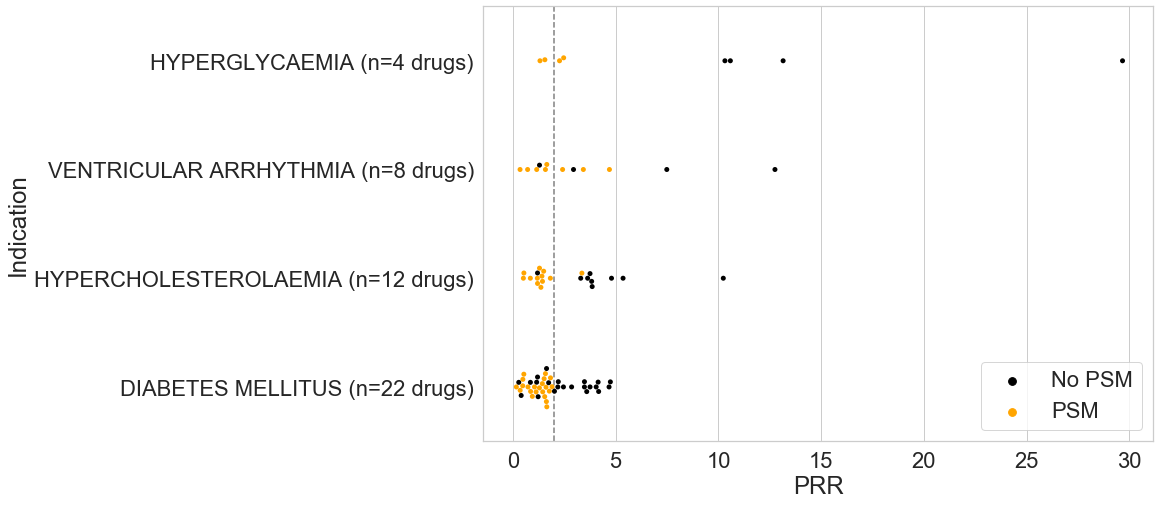

In [71]:
# Left out 'HYPERGLYCAEMIA' beccause fewer than 5 datapoints
selected_AEs = ['VENTRICULAR ARRHYTHMIA', 'HYPERCHOLESTEROLAEMIA', 'DIABETES MELLITUS','HYPERGLYCAEMIA']

current_df = concat_df_inds.loc[concat_df_inds['adverse event'].isin(selected_AEs)]
AE_order = list(pd.DataFrame(current_df.loc[current_df['PSM']=='No PSM',:].groupby('adverse event')['PRR'].quantile(0.75)).sort_values(by='PRR', ascending=False).index)

current_df['adverse event'] = current_df['adverse event'].astype('category')
current_df['adverse event'].cat.set_categories(AE_order, inplace=True)
custom_ae_labels = [row[1]['adverse event'] + ' (n=' + str(row[1]['aeolus_id']) + ' drugs)' for row in pd.DataFrame(current_df.groupby('adverse event')['aeolus_id'].nunique()).reset_index().sort_values(by='aeolus_id').iterrows()]

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.swarmplot(y="adverse event", x="PRR", hue="PSM",data=current_df, palette=['Black', 'Orange'], orient='h', hue_order=['No PSM', 'PSM'], order=AE_order)#, showfliers=False, whis=[10,90]
#ax = sns.swarmplot(y="adverse event", x="PRR", hue="PSM",data=current_df, palette=['steelblue', 'orange'], orient='h', hue_order=['No PSM', 'PSM'], order=AE_order)
plt.axvline(2, color='grey', linestyle='--')
ax.legend().set_title('')
ax.set_yticklabels(custom_ae_labels)

ax.set_ylabel("Indication")
ax.set_xlabel("PRR")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax.set_ylim(0,60)

plt.savefig(project_dir + '/figures/PRRs_Tatonetti_indications.png', bbox_inches='tight', dpi=150)

### Percentage of AE that are indications

In [72]:
# % of significant AEs that is indication - reduced by PSM?
# % of indications that would fall below significant cutoff

In [73]:
concat_df_sign = concat_df.loc[(concat_df['PRR']>=2)&(concat_df['chi-squared statistic']>=4)]

In [74]:
concat_df_sign.head()

,concept id,adverse event,number of exposed affected,total exposed,number of non-exposed affected,total non-exposed,unique non-exposed,fraction of exposed affected,fraction of non-exposed affected,PRR,chi-squared statistic,chi-squared p-value,comment,corrected p-value,aeolus_id,molregno,indication,PSM
0,36211188,THERAPEUTIC AGENT TOXICITY,27,1121,29,11210,4988,0.024086,0.002587,9.310345,99.49,1.973580e-23,NaN,1.835429e-21,700253,2166,0,PSM
1,36818729,PREMATURE BABY,34,1121,40,11210,4988,0.030330,0.003568,8.500000,117.91,1.813784e-27,NaN,3.373638e-25,700253,2166,0,PSM
2,36718119,ENCEPHALOPATHY,29,1121,39,11210,4988,0.025870,0.003479,7.435897,89.12,3.707871e-21,NaN,2.298880e-19,700253,2166,0,PSM
3,36211197,MATERNAL DRUGS AFFECTING FOETUS,22,1121,30,11210,4988,0.019625,0.002676,7.333333,65.74,5.147074e-16,NaN,2.393390e-14,700253,2166,0,PSM
4,36718298,APHASIA,19,1121,27,11210,4988,0.016949,0.002409,7.037037,54.13,1.877924e-13,NaN,5.821565e-12,700253,2166,0,PSM


In [75]:
len(concat_df_sign.loc[concat_df_sign['PSM']=='No PSM',:]), len(concat_df_sign.loc[(concat_df_sign['PSM']=='No PSM')&(concat_df_sign['indication']==1),:])

(189337, 4383)

In [76]:
# Overall percentage of all drug-ae associations in which the AEs is drug indication in No PSM scenario
(len(concat_df_sign.loc[(concat_df_sign['PSM']=='No PSM')&(concat_df_sign['indication']==1),:]) / len(concat_df_sign.loc[concat_df_sign['PSM']=='No PSM',:]))*100

2.3149199575360337

In [77]:
len(concat_df_sign.loc[concat_df_sign['PSM']=='PSM',:]), len(concat_df_sign.loc[(concat_df_sign['PSM']=='PSM')&(concat_df_sign['indication']==1),:])

(74154, 1711)

In [78]:
# Overall percentage of all drug-ae associations in which the AEs is drug indication in PSM scenario

(len(concat_df_sign.loc[(concat_df_sign['PSM']=='PSM')&(concat_df_sign['indication']==1),:])/len(concat_df_sign.loc[concat_df_sign['PSM']=='PSM',:]))*100 

2.307360358173531

In [79]:
concat_df_sign_inds = concat_df_sign.loc[concat_df_sign['molregno'].isin(indications.keys())]

In [80]:
# Check per drug
def report_change_perc_inds(drug):
    no_psm_drug = concat_df_sign_inds.loc[(concat_df_sign_inds['molregno']==drug)&(concat_df_sign_inds['PSM']=='No PSM')]
    psm_drug = concat_df_sign_inds.loc[(concat_df_sign_inds['molregno']==drug)&(concat_df_sign_inds['PSM']=='PSM')]

    if len(psm_drug) < 1 or len(no_psm_drug) < 1:
        return
    
    no_psm_fraction = len(no_psm_drug.loc[no_psm_drug['indication']==1,'adverse event'].drop_duplicates()) / len(no_psm_drug['adverse event'].drop_duplicates())
    psm_fraction = len(psm_drug.loc[psm_drug['indication']==1,'adverse event'].drop_duplicates()) / len(psm_drug['adverse event'].drop_duplicates())

    #change = (psm_fraction - no_psm_fraction) * 100
    
    return (psm_fraction*100, no_psm_fraction*100)

In [81]:
perc_inds_dict = {}
for molregno in overlapping_molregnos:
    current_result = report_change_perc_inds(molregno)
    if current_result:
        psm_fraction = current_result[0]
        no_psm_fraction = current_result[1]
    
    if report_change_perc_inds(molregno):
        perc_inds_dict[molregno] = {'PSM': psm_fraction, 'No PSM': no_psm_fraction}
    

In [82]:
result_df = pd.DataFrame.from_dict(perc_inds_dict, orient='index')

In [83]:
result_df.head()

,PSM,No PSM
36864,0.000000,0.000000
22528,1.176471,1.423488
65538,0.000000,0.000000
675842,5.882353,0.000000
399361,0.000000,1.904762


In [84]:
result_PSM = pd.DataFrame(result_df['PSM'].reset_index(drop=True))
result_PSM.rename(columns={'PSM': 'Percentage of AEs that are indications'}, inplace=True)
result_PSM['PSM'] = 'PSM'
result_no_PSM = pd.DataFrame(result_df['No PSM'].reset_index(drop=True))
result_no_PSM.rename(columns={'No PSM': 'Percentage of AEs that are indications'}, inplace=True)
result_no_PSM['PSM'] = 'No PSM'
result_concatenated = pd.concat([result_PSM, result_no_PSM])

In [85]:
result_concatenated.head()

,Percentage of AEs that are indications,PSM
0,0.000000,PSM
1,1.176471,PSM
2,0.000000,PSM
3,5.882353,PSM
4,0.000000,PSM


In [86]:
observe_diffs_all.head()

,concept id_psm,adverse event,number of exposed affected_psm,total exposed_psm,number of non-exposed affected_psm,total non-exposed_psm,unique non-exposed_psm,fraction of exposed affected_psm,fraction of non-exposed affected_psm,PRR_psm,chi-squared statistic_psm,chi-squared p-value_psm,comment_psm,corrected p-value_psm,aeolus_id_psm,molregno,indication_psm,concept id_no_psm,number of exposed affected_no_psm,total exposed_no_psm,number of non-exposed affected_no_psm,total non-exposed_no_psm,unique non-exposed_no_psm,fraction of exposed affected_no_psm,fraction of non-exposed affected_no_psm,PRR_no_psm,chi-squared statistic_no_psm,chi-squared p-value_no_psm,comment_no_psm,corrected p-value_no_psm,aeolus_id_no_psm,indication_no_psm,PRR after - PRR before
0,36516848,MUSCLE SPASMS,13,1121,36,11210,4988,0.011597,0.003211,3.611111,16.05,6.175833e-05,NaN,5.221386e-04,700253,2166,0,36516848,13,1161,49453,4909224,4909224,0.011197,0.010073,1.111556,0.06,8.131017e-01,NaN,9.183266e-01,700253,0,2.499555
1,36718526,CONVULSION,47,1121,169,11210,4988,0.041927,0.015076,2.781065,41.15,1.412140e-10,NaN,3.283226e-09,700253,2166,0,36718526,52,1161,57793,4909224,4909224,0.044789,0.011772,3.804598,105.87,7.862153e-25,NaN,6.861515e-24,700253,0,-1.023533
2,36311983,HEART RATE INCREASED,29,1121,121,11210,4988,0.025870,0.010794,2.396694,18.04,2.162030e-05,NaN,2.234097e-04,700253,2166,0,36311983,30,1161,29824,4909224,4909224,0.025840,0.006075,4.253398,71.80,2.380124e-17,NaN,1.757630e-16,700253,0,-1.856703
3,36211195,DRUG EXPOSURE DURING PREGNANCY,61,1121,256,11210,4988,0.054416,0.022837,2.382812,39.32,3.590134e-10,NaN,7.419609e-09,700253,2166,0,36211195,63,1161,33999,4909224,4909224,0.054264,0.006926,7.835289,370.75,1.286580e-82,NaN,3.087792e-81,700253,0,-5.452477
4,37320158,ERYTHEMA,29,1121,125,11210,4988,0.025870,0.011151,2.320000,16.73,4.312678e-05,NaN,4.010791e-04,700253,2166,0,37320158,30,1161,45717,4909224,4909224,0.025840,0.009312,2.774752,32.58,1.141104e-08,NaN,6.085887e-08,700253,0,-0.454752


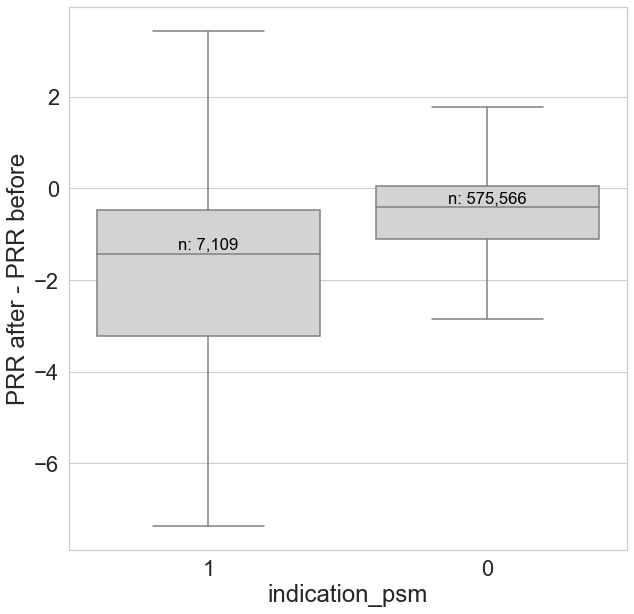

In [87]:
medians = observe_diffs_all.groupby(['indication_psm'])['PRR after - PRR before'].median()
nobs =  observe_diffs_all.groupby(['indication_psm']).apply(lambda x: 'n: {:,}'.format(len(x)))

sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

ax = sns.boxplot(y='PRR after - PRR before', x='indication_psm', data=observe_diffs_all, orient='v', showfliers=False, color='lightgrey', order=[1,0])

for tick, label in enumerate(ax.get_xticklabels()):
    ax_sex = label.get_text()
    num = nobs[int(ax_sex)]
    med_val= medians[int(ax_sex)]

    ax.text(tick , med_val + 0.1, num,
                horizontalalignment='center', size='x-small', color='black')


In [88]:
len(concat_df_sign['molregno'].drop_duplicates())

1112

In [89]:
result_concatenated['PSM'].value_counts()

No PSM    1046
PSM       1046
Name: PSM, dtype: int64

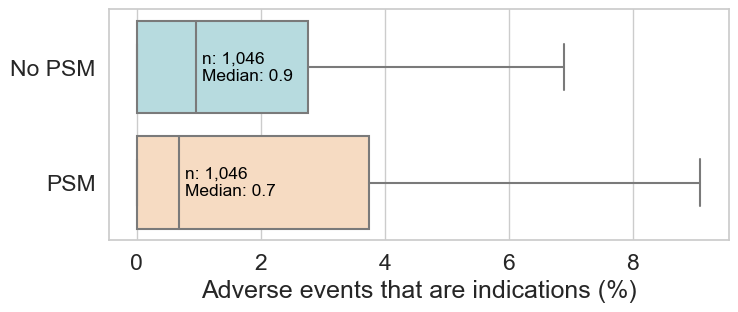

In [128]:
medians = result_concatenated.groupby(['PSM'])['Percentage of AEs that are indications'].median()
nobs =  result_concatenated.groupby(['PSM']).apply(lambda x: 'n: {:,} \nMedian: {:.1f}'.format(len(x), x.median()[0]))


sns.set(rc={'figure.figsize':(8,3)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
ax = sns.boxplot(x='Percentage of AEs that are indications', y='PSM', data=result_concatenated, showfliers=False, palette=['Powderblue', 'peachpuff'], orient='h', order=['No PSM','PSM'])

for tick, label in enumerate(ax.get_yticklabels()):
    ax_sex = label.get_text()
    num = nobs[ax_sex]
    med_val= medians[ax_sex]

    ax.text(med_val + 0.1, tick, num,
                verticalalignment='center', size='x-small', color='black')

ax.set_ylabel("")
ax.set_xlabel('Adverse events that are indications (%)')
plt.savefig(project_dir + '/figures/Perc_AE-ind_per_drug.png', bbox_inches='tight')

In [91]:
result_concatenated.tail()

,Percentage of AEs that are indications,PSM
1041,0.898204,No PSM
1042,0.000000,No PSM
1043,0.000000,No PSM
1044,0.533618,No PSM
1045,3.077975,No PSM


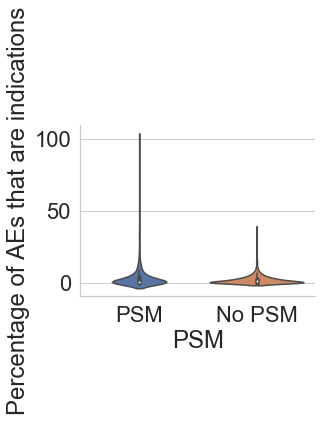

In [95]:
sns.catplot(y="Percentage of AEs that are indications", x="PSM",
            kind="violin", data=result_concatenated)

### Further questions

In [96]:
# is the worsening related to a variety of different indicaitons for a drug? (different SOC counts of drug indications, e.g. aspirin taken for very different indications)
# are some SOCs more susceptible to indicatin bias? 

### Gather data to recreate case studies from Tatonetti using current data

### Current study case studies

In [97]:
# Function to retrieve features/correlated variables used in PSM model building

def retrieve_features(drug_id, corrs_db_path):
    """Return two lists with correlated drugs and correlated indications respectively for given drug.
    drug -- int concept_id of the drug
    inds_corrs_db_path -- str path to the sqlite db containing correlations with indications
    drugs_corrs_db_path -- str path to the sqlite db containing correlations with other drugs"""

    # retrieve previously calculated correlated indications
    conn = sqlite.connect(corrs_db_path)
    cursor = conn.cursor()
    correlated_indications = [(i[0],i[1]) for i in cursor.execute('select indication_id, fishers_odds from indications where bh_pvalue < 0.05 and fishers_odds > 1 and drug_id = {} order by bh_pvalue limit 200'.format(str(drug_id))).fetchall()]

    # retrieve previously calculated correlated indications
    cursor = conn.cursor()
    correlated_drugs = [(i[0],i[1]) for i in cursor.execute('select drug2_id, fishers_odds from drugs where bh_pvalue < 0.05 and fishers_odds > 1 and drug1_id = {} order by bh_pvalue limit 200'.format(str(drug_id))).fetchall()]

    conn.close()

    ind_df = pd.DataFrame(correlated_indications, columns = ['id', 'fishers_odds'])
    ind_df['type'] = 'indication'
    
    drug_df = pd.DataFrame(correlated_drugs, columns = ['id', 'fishers_odds'])
    drug_df['type'] = 'drug'
    
    all_df = ind_df.append(drug_df)
    all_df.sort_values(by = 'fishers_odds', ascending=False, inplace=True)
    
    top_200 = all_df.head(200)

    top_correlated_indications = list(top_200.loc[top_200['type']=='indication',:]['id'])
    top_correlated_drugs = list(top_200.loc[top_200['type']=='drug',:]['id'])

    return top_correlated_drugs, top_correlated_indications


In [98]:
conn = sqlite.connect(correlations)
cursor = conn.cursor()

In [99]:
def append_results(aeolus_drug_id, my_dict):
    
    # Get ids of correlated drugs used in PSM models
    id_list = retrieve_features(drug_id=aeolus_drug_id, corrs_db_path=correlations)[0]
    
    # Get names of drugs
    sql_result = cursor.execute('select distinct drug2_id, drug2_name from drugs where drug2_id in ({})'.format(', '.join([str(i) for i in id_list]))).fetchall()
    
    for item in sql_result:
        aeolus = item[0]
        name = item[1]
        try:
            molregno = aeolus2molregno[aeolus]
            my_dict[name] = molregno
        except KeyError:
            continue

In [100]:
abacavir_coreported = {}
append_results(1736971, abacavir_coreported)

isoniazid_coreported = {}
append_results(1782521, isoniazid_coreported)

pergolide_coreported = {}
append_results(732309, pergolide_coreported)

rofecoxib_coreported = {}
append_results(1189754, rofecoxib_coreported)

In [101]:
conn.close()

In [102]:
coreports_dicts = [abacavir_coreported, isoniazid_coreported, pergolide_coreported, rofecoxib_coreported]
AEs_coreports = ['RASH', 'HEPATIC_FAILURE','MITRAL_VALVE_INCOMPETENCE', 'MYOCARDIAL_INFARCTION']

In [125]:
plt.rcdefaults()

#sns.set(rc={'figure.figsize':(4,5)})
sns.reset_defaults()
sns.set_style('whitegrid')
for dictionary, AE in zip(coreports_dicts, AEs_coreports):
    drug_names = []
    PRRs_before = []
    for drug in sorted(list(dictionary.keys())):
        drug_names.append(drug)
        try:
            PRR = list(no_psm_aes.loc[(no_psm_aes['molregno']==dictionary[drug])&(no_psm_aes['adverse event']==AE.replace('_', ' ')),'PRR'])[0]
            PRRs_before.append(PRR)
        except IndexError:
            PRRs_before.append(None)
    PRRs_after = []
    for drug in sorted(list(dictionary.keys())):
        try:
            PRR = list(psm_aes.loc[(psm_aes['molregno']==dictionary[drug])&(psm_aes['adverse event']==AE.replace('_', ' ')),'PRR'])[0]
            PRRs_after.append(PRR)
        except IndexError:
            PRRs_after.append(None)

    df = pd.DataFrame.from_dict({'PRR before': PRRs_before, 'PRR after': PRRs_after, 'names': drug_names})
    df_selected = df.loc[(~df['PRR before'].isnull())&(~df['PRR after'].isnull())]
    df_selected.sort_values(by='PRR before', ascending=False, inplace=True)
    df_selected.reset_index(drop=True, inplace=True)
    if len(df_selected) > 0:
        x = df_selected['PRR before']
        x2 = df_selected['PRR after']
        y = [i+1 for i in df_selected.index]
        labels = df_selected['names']
        
        sns.set(rc={'figure.figsize':(5,len(labels)/4)})
        sns.set_style('whitegrid')
        ax = plt.subplot(111)
        for num in range(1, len(df_selected) + 1):
            plt.axhline(y=num, color='lightGray')
        plt.axvline(x=0, color='lightGray')
        plt.plot(x, y, 'ro', color='LightBlue', label='No PSM', marker='D')
        plt.plot(x2, y, 'ro', color='Orange', label='PSM')
        plt.yticks(y, labels, fontsize=8)
        plt.xticks(fontsize=8)
        plt.margins(0.05)


        box = ax.get_position()
        ax.legend(loc='best', fontsize=8)
        #ax.legend(numpoints=1, loc=10, bbox_to_anchor=(1.15, box.y0))
        plt.xlabel('PRR', fontsize=8)

        ttl = ax.title
        ttl.set_position([.5, 1.03])

        plt.savefig(project_dir + '/figures/CurrentStudy_{}_differences.png'.format(AE.replace(' ', '_')), dpi = 199, bbox_inches='tight')
        plt.close()

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Recreate Tatonetti's exact case studies

In [104]:
# Drugs co-reported with abacavir # Rash
RASH = {'abacavir' : 321707, 'clarithromycin' : 570147, 'foscarnet': 27780, 'azithromycin' : 12428, 'atovaquone' : 378315, 'pyrimethamine' : 2080, 'nevirapine' : 4345, 'darunavir' : 267163, 'sulfadiazine' : 2131, 'fosamprenavir' : 499624, 'amprenavir' : 17347}

# Drugs co-reported with isoniazid # hepatic failure
HEPATIC_FAILURE = {'fluconazole': 13758, 'ofloxacin': 146, 'isoniazid' : 4941, 'prednisolone' : 27370, 'efavirenz' : 374719, 'clarithromycin' : 570147, 'abacavir' : 321707, 'tenofovir' : 6012, 'cyclosporine' : 72873, 'lamivudine' : 33986, 'nevirapine' : 4345, 'rifampicin' : 365189, 'stavudine' : 107119, 'ethambutol' : 67617, 'didanosine' : 390877, 'pyrazinamide' : 23522, 'streptomycin' : 334866}

# Drugs co-reported with pergolide 'heart valve damage'

HEART_VALVE_DAMAGE = {'pergolide' : 12494, 'orphenadrine' : 77779, 'entacapone' : 92412, 'selegiline' : 96021, 'tolcapone' : 267825, 'trihexyphenidyl' : 418411, 'amantadine' : 27647, 'cabergoline': 675038}

# Drugs co-reported with rofecoxib # 'myocardial infarction'
MYOCARDIAL_INFARCTION = {'rofecoxib' : 21697,'dicyclomine': 165774, 'quinapril': 454141, 'nabumetone': 139210, 'benazepril': 61706, 'amitriptyline': 27072, 'clopidogrel': 598402, 'methocarbamol': 675068, 'oxaprozin': 139225, 'tramadol' : 699395, 'nitroglycerin': 37493, 'trazodone' : 26401, 'cerivastatin' : 403465, 'valdecoxib' : 67010, 'celecoxib' : 18694 }

# Drugs used in patients with arrhythmia # Arrhythmia
ARRHYTHMIA = {'quinidine' : 27150, 'verapamil' : 1219, 'mexiletine' : 15958 ,'diltiazem' : 1278, 'amiodarone' : 27185, 'propafenone' : 27112, 'flecainide' : 27588, 'sotalol' : 5528, 'dofetilide' : 5638, 'disopyramide' : 11143}

# Cholesterol lowering agents 'Hypercholestermia'
HYPERCHOLESTEROLAEMIA = {'lovastatin' : 9495, 'simvastatin' : 138562, 'rosuvastatin' : 418845, 'fluvastatin' : 140116, 'fenofibrate' : 28331, 'pravastatin' : 178796, 'ezetimibe' : 175106, 'gemfibrozil' : 2994, 'atorvastatin' :417180, 'cerivastatin' : 403465}

HYPERGLYCAEMIA = {'lisinopril': 230659, 'acarbose': 436875, 'chlorpropamide': 8516, 'rosiglitazone': 20027, 'metformin': 369464, 'pioglitazone': 19737, 'glyburide': 5582, 'repaglinide': 248669, 'glimepiride': 405366, 'nateglinide': 46727, 'glipizide': 139286}

In [105]:
dictionary_list = [RASH, HEPATIC_FAILURE,HEART_VALVE_DAMAGE, MYOCARDIAL_INFARCTION, ARRHYTHMIA, HYPERCHOLESTEROLAEMIA, HYPERGLYCAEMIA]
AEs = ['RASH', 'HEPATIC_FAILURE','MITRAL_VALVE_INCOMPETENCE', 'MYOCARDIAL_INFARCTION','ARRHYTHMIA','HYPERCHOLESTEROLAEMIA', 'HYPERGLYCAEMIA']

In [123]:
#sns.set(rc={'figure.figsize':(4,5)})
sns.reset_defaults()

sns.set_style('whitegrid')
for dictionary, AE in zip(dictionary_list, AEs):
    drug_names = []
    PRRs_before = []
    for drug in sorted(list(dictionary.keys())):
        drug_names.append(drug)
        try:
            PRR = list(no_psm_aes.loc[(no_psm_aes['molregno']==dictionary[drug])&(no_psm_aes['adverse event']==AE.replace('_', ' ')),'PRR'])[0]
            PRRs_before.append(PRR)
        except IndexError:
            PRRs_before.append(None)
    PRRs_after = []
    for drug in sorted(list(dictionary.keys())):
        try:
            PRR = list(psm_aes.loc[(psm_aes['molregno']==dictionary[drug])&(psm_aes['adverse event']==AE.replace('_', ' ')),'PRR'])[0]
            PRRs_after.append(PRR)
        except IndexError:
            PRRs_after.append(None)

    df = pd.DataFrame.from_dict({'PRR before': PRRs_before, 'PRR after': PRRs_after, 'names': drug_names})
    df_selected = df.loc[(~df['PRR before'].isnull())&(~df['PRR after'].isnull())]
    df_selected.sort_values(by='PRR before', ascending=False, inplace=True)
    df_selected.reset_index(drop=True, inplace=True)
    if len(df_selected) > 0:
        x = df_selected['PRR before']
        x2 = df_selected['PRR after']
        y = [i+1 for i in df_selected.index]
        labels = df_selected['names']
        
        sns.set(rc={'figure.figsize':(5,len(labels)/4)})
        if AE == 'MITRAL_VALVE_INCOMPETENCE':
            sns.set(rc={'figure.figsize':(4,2)})

        sns.set_style('whitegrid')
        ax = plt.subplot(111)
        for num in range(1, len(df_selected) + 1):
            plt.axhline(y=num, color='lightGray')
        plt.axvline(x=0, color='lightGray')
        plt.plot(x, y, 'ro', color='LightBlue', label='No PSM', marker='D')
        plt.plot(x2, y, 'ro', color='Orange', label='PSM')
        plt.yticks(y, labels, fontsize=8)
        plt.xticks(fontsize=8)
        plt.margins(0.05)

        box = ax.get_position()
        ax.legend(loc='best', fontsize=8)
        if AE == 'ARRHYTHMIA':
            ax.legend(loc='upper right')

        #ax.legend(numpoints=1, loc=10, bbox_to_anchor=(1.3, box.y0))
        plt.xlabel('PRR', size=8)

        ttl = ax.title
        ttl.set_position([.5, 1.03])

        plt.savefig(project_dir + '/figures/Tatonetti_{}_differences.png'.format(AE.replace(' ', '_')), dpi = 199, bbox_inches='tight')
        plt.close()

/scratch/ias41/envs/release/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Which SOCs do AEs belong to?
### Are AEs in same SOC as indication?

In [97]:
ind_soc2molregno = {}
for ind in list(meddra_hlgt['SOC'].drop_duplicates()):
    ind_soc2molregno[ind] = set()

In [98]:
# make dictionary of SOCs of indications per drug

molregno2ind_soc = {}
for molregno in overlapping_molregnos:
    molregno2ind_soc[molregno] = set()
    
    for ind in indications[molregno]:
        try:
            soc = term2soc[ind]
            molregno2ind_soc[molregno].add(soc)
            ind_soc2molregno[soc].add(molregno)
        except KeyError:
            continue

In [99]:
# Remove indications with no drugs
to_remove = []
for key, value in ind_soc2molregno.items():
    if len(value) < 1:
        to_remove.append(key)
for key in to_remove:
    del(ind_soc2molregno[key])

In [100]:
# Remove drugs with no indications that had SOC
to_remove = []
for key, value in molregno2ind_soc.items():
    if len(value) < 1:
        to_remove.append(key)
for key in to_remove:
    del(molregno2ind_soc[key])

In [101]:
# For each SOC
# Gather all drugs with that indication, what % of all unique AEs is in same SOC? what % is different SOC? what % is indication?


In [122]:
psm_aes_soc = psm_aes.merge(meddra_hlgt.loc[meddra_hlgt['Primary SOC']=='Y',:], left_on='adverse event', right_on='Term')
psm_aes_soc_sign = psm_aes_soc.loc[(psm_aes_soc['chi-squared statistic']>=4)&(psm_aes_soc['PRR']>=2),['adverse event', 'molregno', 'indication', 'SOC']].drop_duplicates()

In [123]:
psm_aes_soc_sign.head(200)

,adverse event,molregno,indication,SOC
0,THERAPEUTIC AGENT TOXICITY,2166,0,"Injury, poisoning and procedural complications"
16,THERAPEUTIC AGENT TOXICITY,9372,0,"Injury, poisoning and procedural complications"
19,THERAPEUTIC AGENT TOXICITY,675154,0,"Injury, poisoning and procedural complications"
31,THERAPEUTIC AGENT TOXICITY,1051118,0,"Injury, poisoning and procedural complications"
34,THERAPEUTIC AGENT TOXICITY,921,0,"Injury, poisoning and procedural complications"
...,...,...,...,...
1411,MATERNAL DRUGS AFFECTING FOETUS,142808,0,"Injury, poisoning and procedural complications"
1416,MATERNAL DRUGS AFFECTING FOETUS,51182,0,"Injury, poisoning and procedural complications"
1426,MATERNAL DRUGS AFFECTING FOETUS,14125,0,"Injury, poisoning and procedural complications"
1428,MATERNAL DRUGS AFFECTING FOETUS,189203,0,"Injury, poisoning and procedural complications"


In [ ]:
# check if would change drug_ind_count to both ==1 and being the curren soc, if % IND goes down? across plot seems higher than overall total 2.3%

In [124]:
soc_info_dict = {}

for soc in ind_soc2molregno:
    current_molregnos = ind_soc2molregno[soc]
    
    current_df = psm_aes_soc_sign.loc[psm_aes_soc_sign['molregno'].isin(current_molregnos)]
    
    drug_ae_pairs_count = len(current_df[['adverse event','molregno']].drop_duplicates())
    drug_ind_count = len(current_df.loc[current_df['indication']==1,['adverse event','molregno']].drop_duplicates())
    drug_ae_same_soc_count = len(current_df.loc[(current_df['SOC']==soc)&(current_df['indication']==0),['adverse event','molregno']].drop_duplicates())
    drug_ae_other_soc_count = len(current_df.loc[(current_df['SOC']!=soc)&(current_df['indication']==0),['adverse event','molregno']].drop_duplicates())
    
    soc_n = soc + " (n = {:,})".format(drug_ae_pairs_count)
    
    soc_info_dict[soc_n] = {'Drug-AE pairs': drug_ae_pairs_count, 'Indication': (drug_ind_count/drug_ae_pairs_count)*100, 'Adverse event in same System Organ Class': (drug_ae_same_soc_count/drug_ae_pairs_count)*100, 'Adverse event in other System Organ Class': (drug_ae_other_soc_count/drug_ae_pairs_count)*100}

In [125]:
soc_info_df = pd.DataFrame.from_dict(soc_info_dict, orient='index').sort_values(by=['Adverse event in other System Organ Class'], ascending=[False])

In [126]:
soc_info_df.index.name = 'Indication (System Organ Class)'

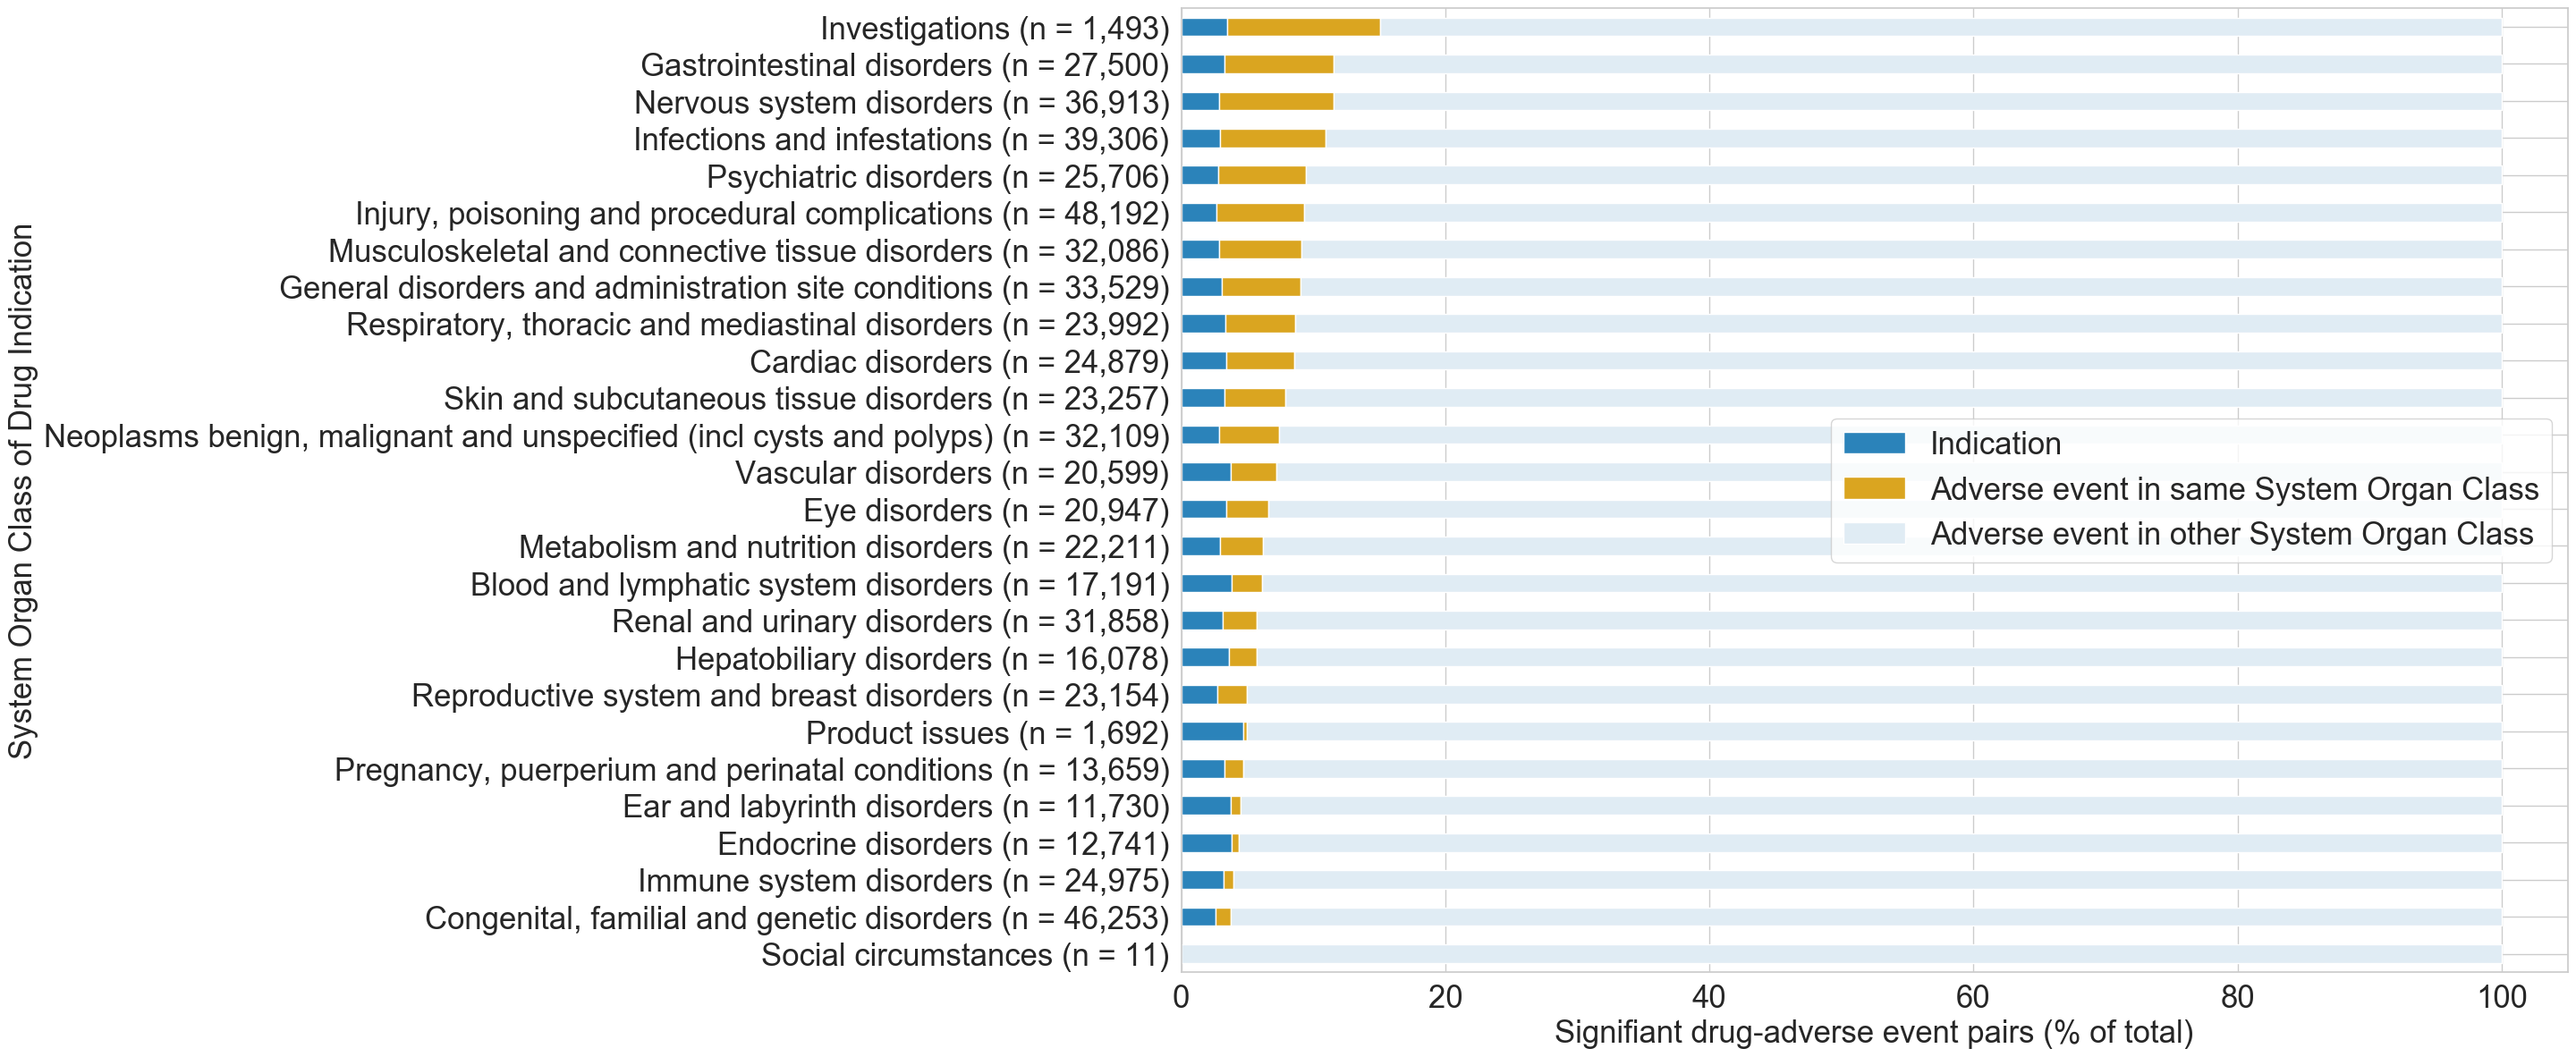

In [127]:
soc_info_df[['Indication',
       'Adverse event in same System Organ Class',
       'Adverse event in other System Organ Class']].plot.barh(stacked=True, figsize=(20,14), color=['#2b83ba', 'goldenrod', '#e0ecf4'], fontsize=25)
plt.xlabel('Signifiant drug-adverse event pairs (% of total)', fontsize=25)
plt.ylabel('System Organ Class of Drug Indication', fontsize=25)
plt.legend(fontsize=25)
plt.savefig(project_dir + '/figures/Perc_Total_drug_ae_pairs.png', dpi = 199, bbox_inches='tight')


In [128]:
for k,v in molregno2ind_soc.items():
    if v=='Product issues':
        print(k)

In [109]:
indications[635] # 635 is flumazenil, antidote to overdoses

{'ADVERSE DRUG REACTION',
 'ADVERSE DRUG REACTION NOS',
 'ADVERSE EVENT',
 'ADVERSE EVENT FOLLOWING IMMUNISATION',
 'ADVERSE REACTION',
 'DERMAL ABSORPTION IMPAIRED',
 'DEVICE INEFFECTIVE',
 'DRUG EFFECT DECREASED',
 'DRUG EFFECT DELAYED',
 'DRUG EFFECT INCOMPLETE',
 'DRUG EFFECT INCREASED',
 'DRUG EFFECT PROLONGED',
 'DRUG EFFECT VARIABLE',
 'DRUG INEFFECTIVE',
 'DRUG INEFFECTIVE FOR UNAPPROVED INDICATION',
 'DRUG INTOLERANCE',
 'DRUG OVERDOSE',
 'DRUG RESISTANCE',
 'DRUG SIDE EFFECT',
 'DRUG TOLERANCE',
 'DRUG TOLERANCE DECREASED',
 'DRUG TOLERANCE INCREASED',
 'ENZYME INDUCTION',
 'ENZYME INHIBITION',
 'ESTROGENIC EFFECT',
 'HABITUATION',
 'IDIOSYNCRATIC DRUG REACTION',
 'IMMEDIATE POST-INJECTION REACTION',
 'INADEQUATE ANALGESIA',
 'INTENTIONAL OVERDOSE',
 'MULTIPLE DRUG OVERDOSE',
 'MULTIPLE DRUG OVERDOSE INTENTIONAL',
 'MULTIPLE-DRUG RESISTANCE',
 'NEGATIVE CARDIAC INOTROPIC EFFECT',
 'NO REACTION ON PREVIOUS EXPOSURE TO DRUG',
 'NO THERAPEUTIC RESPONSE',
 'OESTROGENIC EFFECT',
 

In [110]:
ind_soc2molregno['Product issues']

{635,
 6723,
 20881,
 21716,
 27029,
 30180,
 60319,
 63949,
 82721,
 112480,
 151063,
 169111,
 188815,
 304381,
 308201,
 380567,
 394165,
 394229,
 397524,
 445395,
 502152,
 510462,
 567195,
 624467,
 675153,
 675454,
 675528,
 675574,
 675608,
 1248760,
 1376019,
 1378319,
 1380840}

In [111]:
# Do above graph per drug instead, then take mean per SOC

In [129]:
soc_drug_counts = dict()
for soc in list(ind_soc2molregno.keys()):
    soc_drug_counts[soc] = {'SOC':[],'molregno':[], 'Percentages': [], 'Type': []}


for group in psm_aes_soc_sign.groupby(['molregno']):
    
    molregno = group[0]
    if molregno not in overlapping_molregnos:
        continue
    try:
        SOCs_of_indications = molregno2ind_soc[molregno]
    except KeyError:
        continue
    
    current_df = group[1]
    total_nr_aes = len(current_df)
    
    for soc in SOCs_of_indications:
        aes_ind = len(current_df.loc[current_df['indication']==1])
        aes_same_soc = len(current_df.loc[(current_df['indication']==0)&(current_df['SOC'].isin([soc]))])
        aes_diff_soc = len(current_df.loc[(current_df['indication']==0)&(~current_df['SOC'].isin([soc]))])

        perc_ind = (aes_ind / total_nr_aes) * 100
        perc_same_soc = (aes_same_soc / total_nr_aes) * 100
        perc_diff_soc = (aes_diff_soc / total_nr_aes) * 100
        
        for number, perc_type in zip([perc_ind, perc_same_soc, perc_diff_soc], ['Indication', 'Adverse event in same SOC', 'Adverse event in other SOC']):
            soc_drug_counts[soc]['SOC'].append(soc)
            soc_drug_counts[soc]['molregno'].append(molregno)
            soc_drug_counts[soc]['Percentages'].append(number)
            soc_drug_counts[soc]['Type'].append(perc_type)
            


In [130]:
soc_drug_percentages_df = pd.concat([pd.DataFrame.from_dict(soc_drug_counts[soc]) for soc in soc_drug_counts.keys()])

In [139]:
soc_drug_percentages_df.head(20)

,SOC,molregno,Percentages,Type,SOC + n
0,Eye disorders,97,0.000000,Indication,Eye disorders (n=277 drugs)
1,Eye disorders,97,0.000000,Adverse event in same SOC,Eye disorders (n=277 drugs)
2,Eye disorders,97,100.000000,Adverse event in other SOC,Eye disorders (n=277 drugs)
3,Eye disorders,115,2.094241,Indication,Eye disorders (n=277 drugs)
4,Eye disorders,115,1.047120,Adverse event in same SOC,Eye disorders (n=277 drugs)
5,Eye disorders,115,96.858639,Adverse event in other SOC,Eye disorders (n=277 drugs)
6,Eye disorders,146,3.278689,Indication,Eye disorders (n=277 drugs)
7,Eye disorders,146,6.557377,Adverse event in same SOC,Eye disorders (n=277 drugs)
8,Eye disorders,146,90.163934,Adverse event in other SOC,Eye disorders (n=277 drugs)
9,Eye disorders,173,1.041667,Indication,Eye disorders (n=277 drugs)


In [132]:
len_dict = pd.DataFrame(soc_drug_percentages_df.groupby(['SOC'])['molregno'].nunique()).to_dict()['molregno']

In [133]:
soc_drug_percentages_df['SOC + n'] = soc_drug_percentages_df['SOC'].apply(lambda x: x + ' (n={} drugs)'.format(len_dict[x]))

In [134]:
unstacked = soc_drug_percentages_df.groupby(['SOC + n','Type'])[['Percentages']].mean().unstack(level=-1)

In [135]:
unstacked.columns = ['Adverse event in other SOC', 'Adverse event in same SOC','Indication']

In [136]:
unstacked.sort_values(by=['Adverse event in same SOC'], ascending=True,inplace=True)

In [142]:
unstacked.tail()

,Adverse event in other SOC,Adverse event in same SOC,Indication
SOC + n,,,
Gastrointestinal disorders (n=338 drugs),86.605432,8.877503,4.517066
Psychiatric disorders (n=333 drugs),87.391214,9.246009,3.362777
General disorders and administration site conditions (n=438 drugs),85.888124,9.876074,4.235802
Nervous system disorders (n=471 drugs),85.784833,10.148244,4.066923
Investigations (n=25 drugs),84.979600,11.105315,3.915085


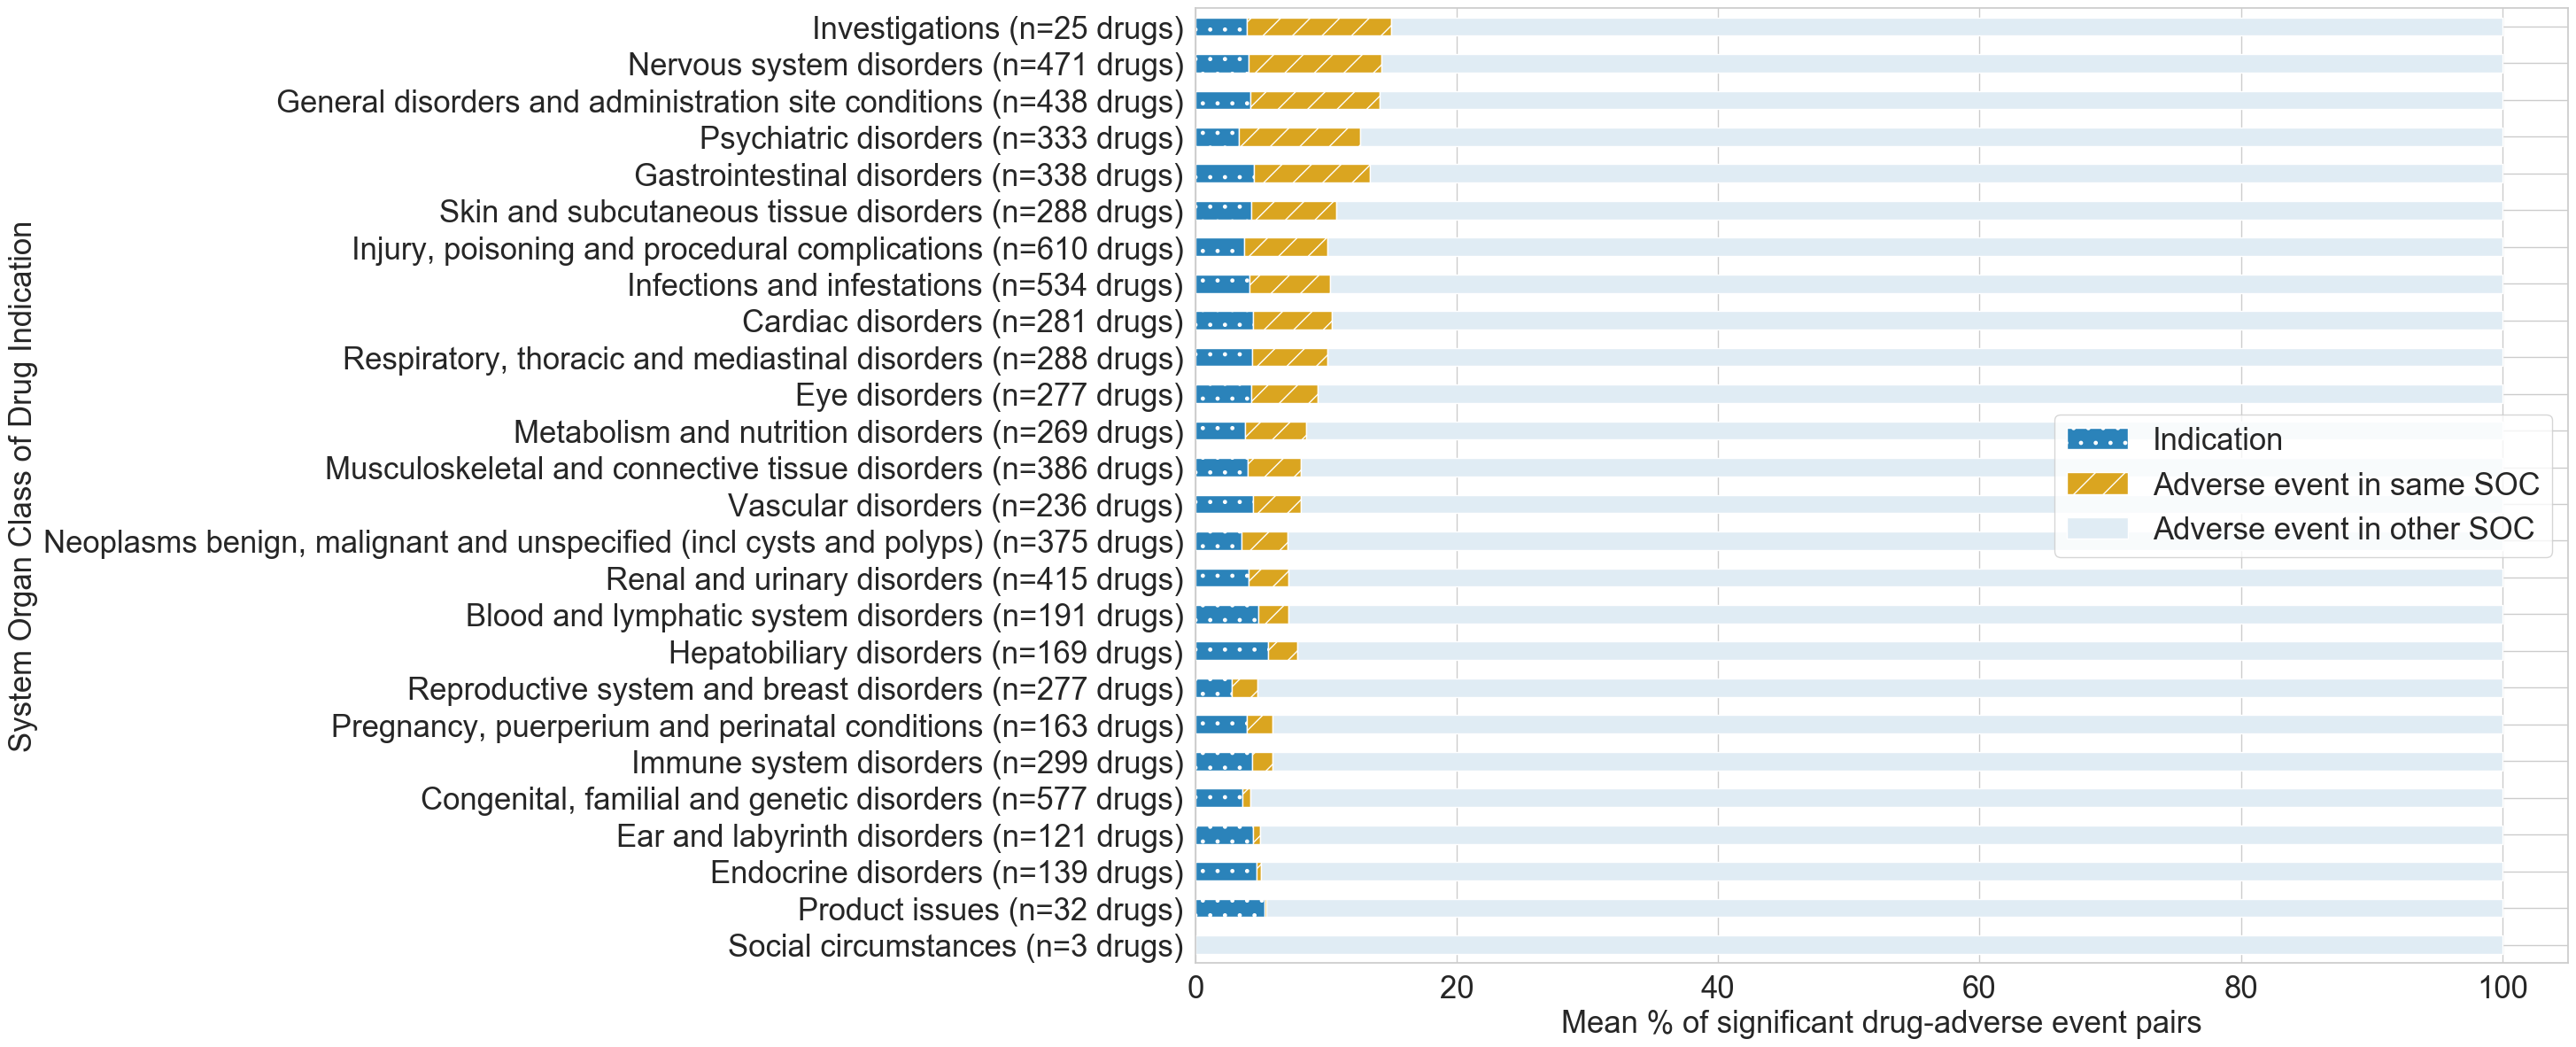

In [138]:
ax = unstacked[['Indication','Adverse event in same SOC','Adverse event in other SOC']].plot.barh(stacked=True, figsize=(20,14), color=['#2b83ba', 'goldenrod', '#e0ecf4'], fontsize=25)
plt.ylabel('System Organ Class of Drug Indication', fontsize=25)
plt.xlabel('Mean % of significant drug-adverse event pairs', fontsize=25)

bars = ax.patches
patterns =('.', '/', '')
hatches = [p for p in patterns for i in range(len(unstacked[['Indication','Adverse event in same SOC','Adverse event in other SOC']]))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

plt.legend(fontsize=25)
plt.savefig(project_dir + '/figures/Perc_Mean_drug_ae_pairs.png', dpi = 150, bbox_inches='tight')
